In [10]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier



import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import fairlearn

In [29]:
df=pd.read_csv('two-years-recid.csv')#.set_index('id')
df

,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,...,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,...,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,...,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6109,6110,seccunda davis,Male,1987-05-13,28,African-American,2013-08-18 07:25:24,2013-08-19 09:01:42,13015644MM10A,2013-08-18,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
6110,6111,mark montgomery,Male,1985-11-03,30,African-American,2013-03-23 01:32:34,2013-03-28 09:37:27,13005696MM10A,2013-03-23,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
6111,6112,erica johnson,Female,1982-06-23,33,Caucasian,2013-09-29 09:25:30,2013-09-30 09:59:37,13013661CF10A,2013-09-29,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
6112,6113,barry williams,Male,1988-04-22,27,African-American,2013-10-30 03:40:14,2013-12-07 01:53:45,13004112MM10A,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [30]:
# 1. Introduction to the Dataset
print("The dataset contains information on recidivism, including demographics, criminal history, and recidivism scores.")

# 2. Data Overview
print(f"The dataset contains {df.shape[0]} records and {df.shape[1]} features.")


The dataset contains information on recidivism, including demographics, criminal history, and recidivism scores.
The dataset contains 6114 records and 35 features.


In [31]:
##Goal: is to analyse whether or not the defendant is likely to commit new crimes in the two years after being released from jail,

## REMOVING ROWS FOR GOAL

In [32]:
df = df.dropna(subset=['c_jail_out'])

# Suppose df_test has some different values, so we'll modify it directly
# Convert columns to datetime if they are not already
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])

df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])


#df.drop(columns=['two_year_recid'], inplace=True)
### Clean dataset to target variable

# Calculate the difference between 'r_offense_date' and 'c_jail_out'
df['offense_jail_duration'] = (df['r_offense_date'] - df['c_jail_out']).dt.days

# Create a new column based on your conditions
df['two_year_recid'] = ((df['is_recid'] == 1) & (df['offense_jail_duration'] <= 365 * 2)).astype(int)

#
df['is_recid']=df['two_year_recid']

/tmp/ipykernel_2385/3120417259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_2385/3120417259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
/tmp/ipykernel_2385/3120417259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

### Start GPT

The dataset contains information on recidivism, including demographics, criminal history, and recidivism scores.
The dataset contains 5854 records and 51 features.
               age  juv_fel_count  juv_misd_count  juv_other_count  \
count  5854.000000    5854.000000     5854.000000       5854.00000   
mean     34.602494       0.063205        0.091561          0.10591   
std      11.723304       0.398745        0.490282          0.44983   
min      18.000000       0.000000        0.000000          0.00000   
25%      25.000000       0.000000        0.000000          0.00000   
50%      31.000000       0.000000        0.000000          0.00000   
75%      42.000000       0.000000        0.000000          0.00000   
max      96.000000      10.000000       13.000000          9.00000   

       priors_count  decile_score  v_decile_score  
count   5854.000000   5854.000000     5854.000000  
mean       3.459857      4.490092        3.693201  
std        4.906369      2.847419        2.502040

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

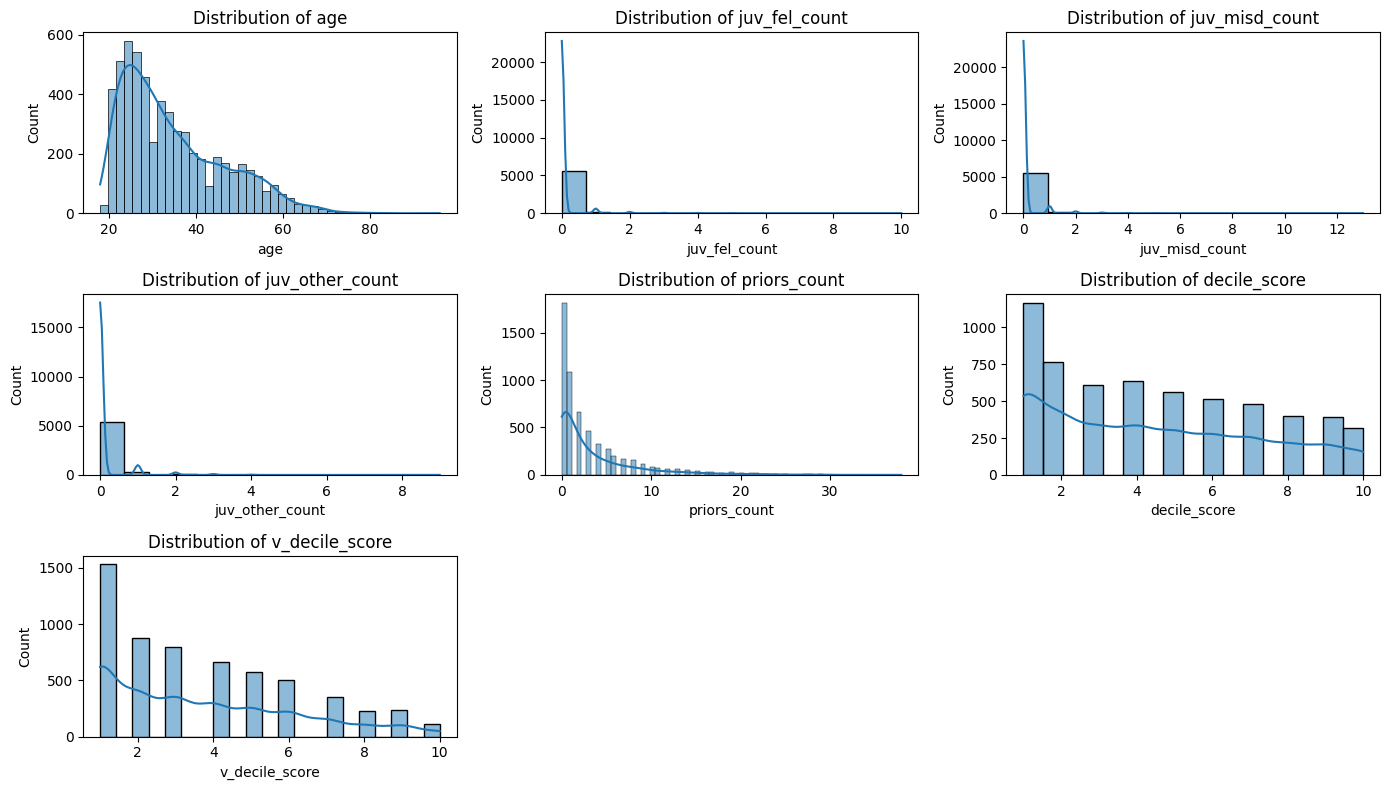

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


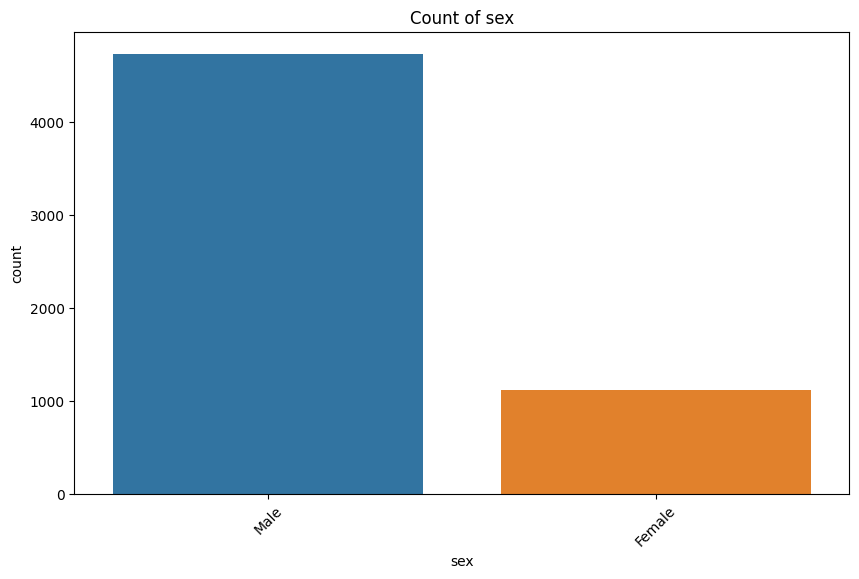

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


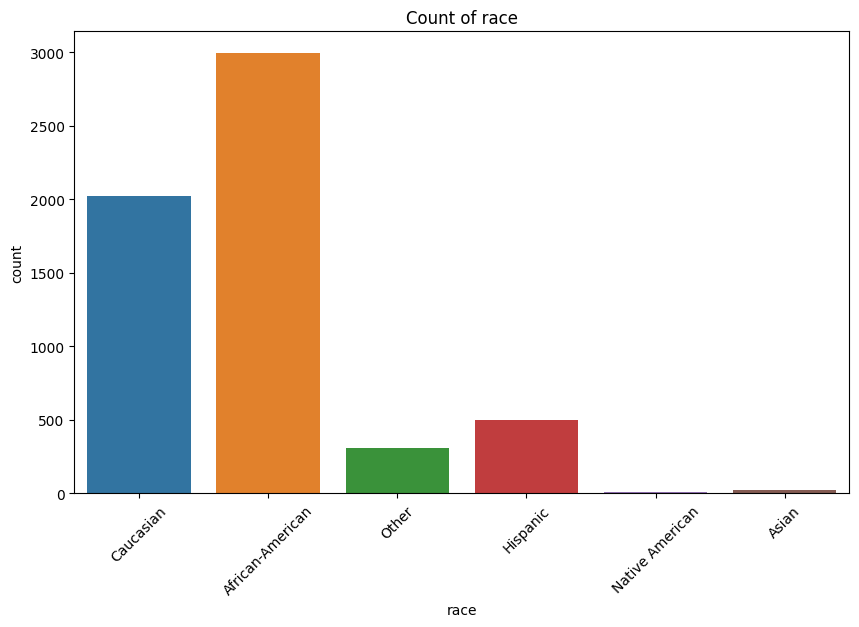

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


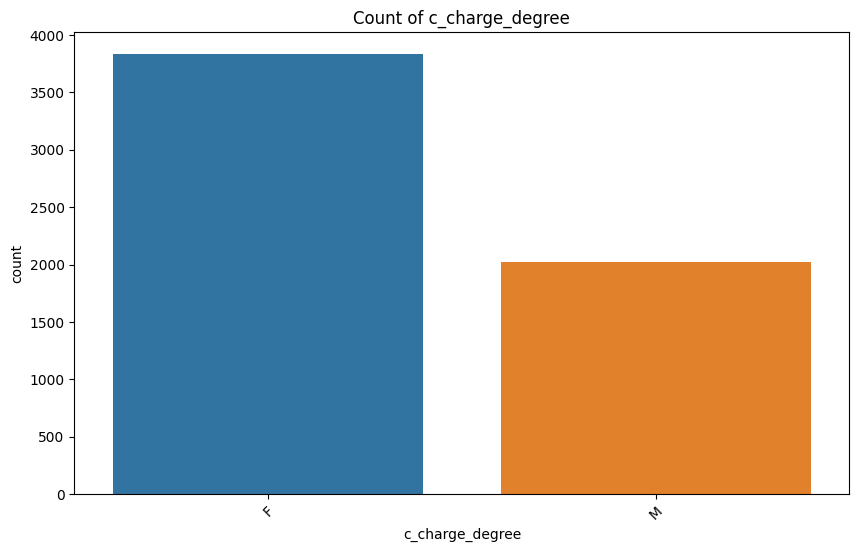

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


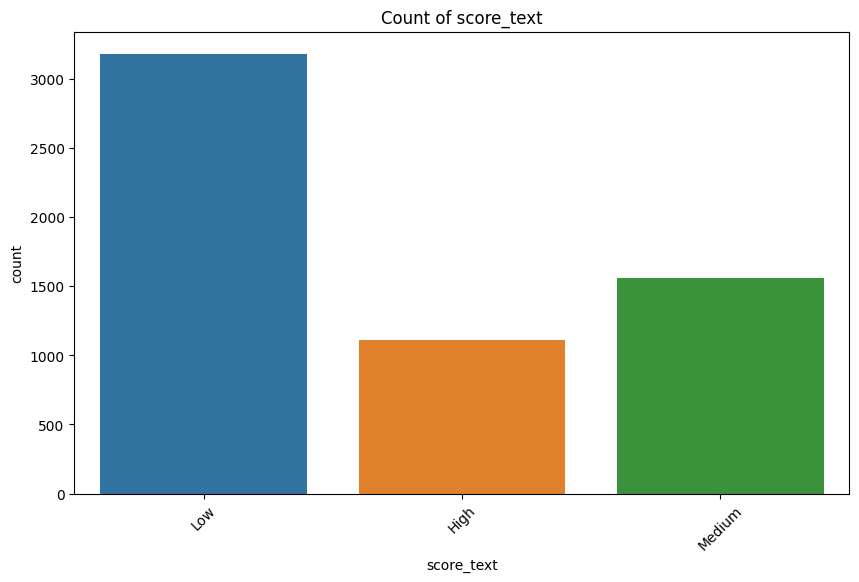

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


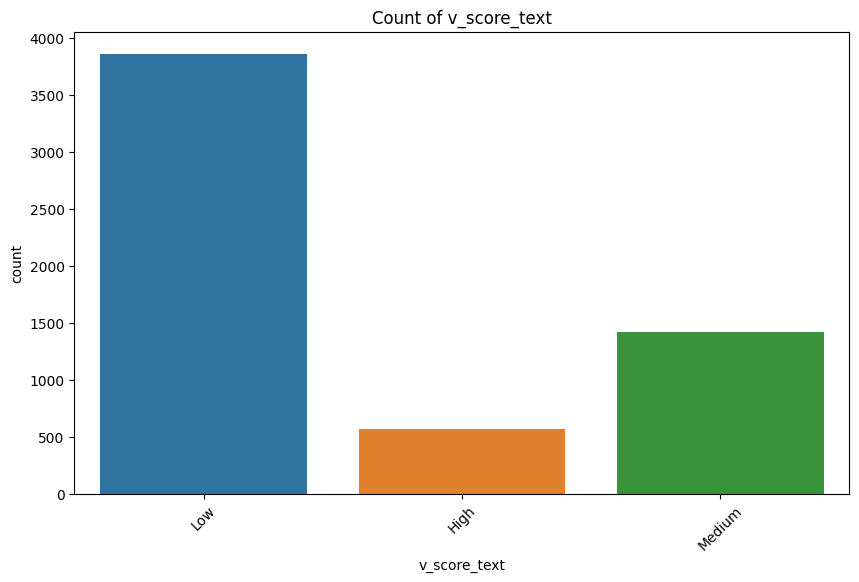

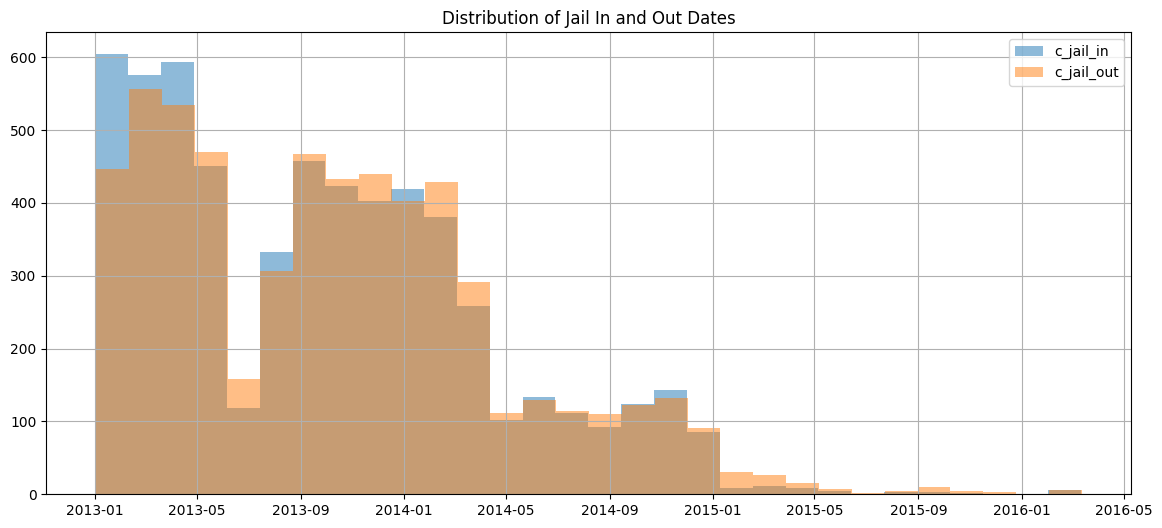

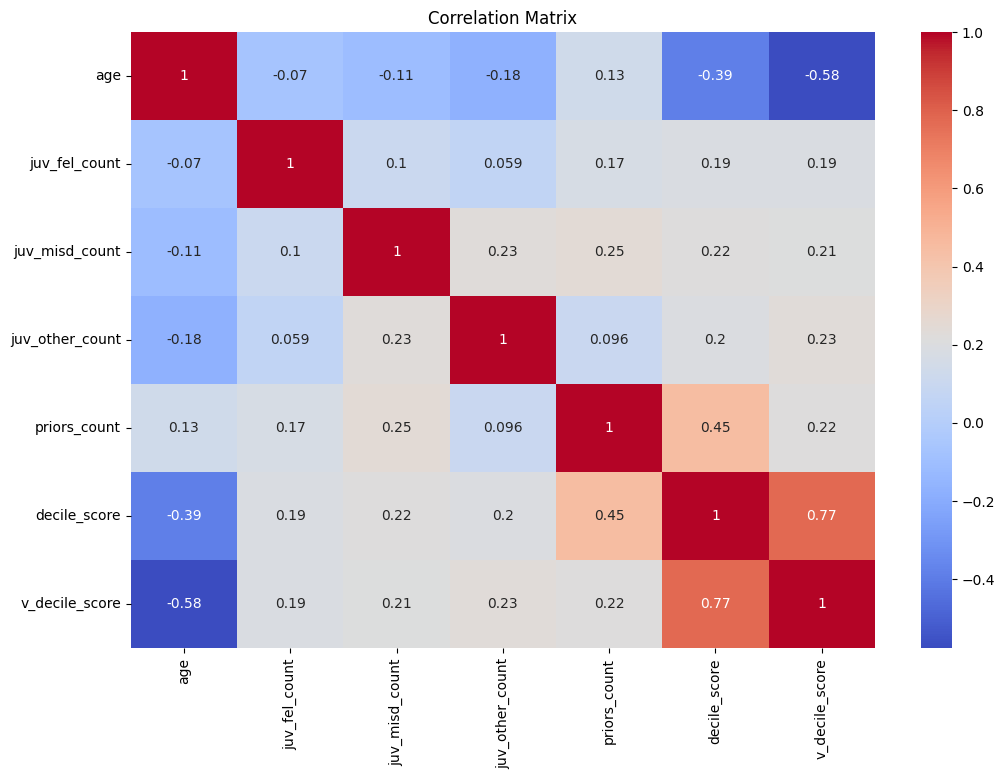

Number of cases where c_jail_out is before c_jail_in: 0
Number of cases where c_jail_in is before c_arrest_date: 83
Number of cases where c_jail_in is before c_offense_date: 31


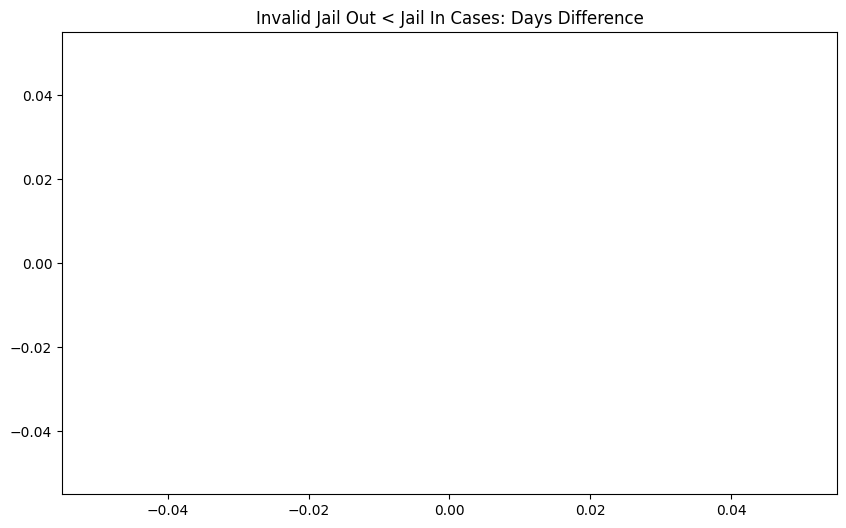

Initial Insights:
1. The majority of defendants are of a certain age range.
2. There are notable differences in recidivism rates across different races and charge degrees.
3. Data quality issues such as incorrect dates need to be addressed for accurate analysis.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert dates to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])



# 1. Introduction to the Dataset
print("The dataset contains information on recidivism, including demographics, criminal history, and recidivism scores.")

# 2. Data Overview
print(f"The dataset contains {df.shape[0]} records and {df.shape[1]} features.")

# 3. Descriptive Statistics
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'decile_score', 'v_decile_score']
print(df[numerical_features].describe())

# Visualizations for numerical features
plt.figure(figsize=(14, 8))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# 4. Categorical Data Analysis
categorical_features = ['sex', 'race', 'c_charge_degree', 'score_text', 'v_score_text']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=feature)
    plt.title(f'Count of {feature}')
    plt.xticks(rotation=45)
    plt.show()

# 5. Date Features Analysis
plt.figure(figsize=(14, 6))
df['c_jail_in'].hist(bins=30, alpha=0.5, label='c_jail_in')
df['c_jail_out'].hist(bins=30, alpha=0.5, label='c_jail_out')
plt.legend()
plt.title('Distribution of Jail In and Out Dates')
plt.show()

# 6. Correlation Analysis
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 7. Data Quality Issues
# Invalid dates
invalid_jail_out = df['c_jail_out'] < df['c_jail_in']
invalid_arrest_date = df['c_jail_in'] < df['c_arrest_date']
invalid_offense_date = df['c_jail_in'] < df['c_offense_date']

print(f"Number of cases where c_jail_out is before c_jail_in: {invalid_jail_out.sum()}")
print(f"Number of cases where c_jail_in is before c_arrest_date: {invalid_arrest_date.sum()}")
print(f"Number of cases where c_jail_in is before c_offense_date: {invalid_offense_date.sum()}")

# Visualize the invalid cases
plt.figure(figsize=(10, 6))
sns.histplot((df['c_jail_in'] - df['c_jail_out']).dt.days[invalid_jail_out], bins=30, kde=True)
plt.title('Invalid Jail Out < Jail In Cases: Days Difference')
plt.show()

# 8. Potential Insights
print("Initial Insights:")
print("1. The majority of defendants are of a certain age range.")
print("2. There are notable differences in recidivism rates across different races and charge degrees.")
print("3. Data quality issues such as incorrect dates need to be addressed for accurate analysis.")


In [188]:
#pip install lifelines

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


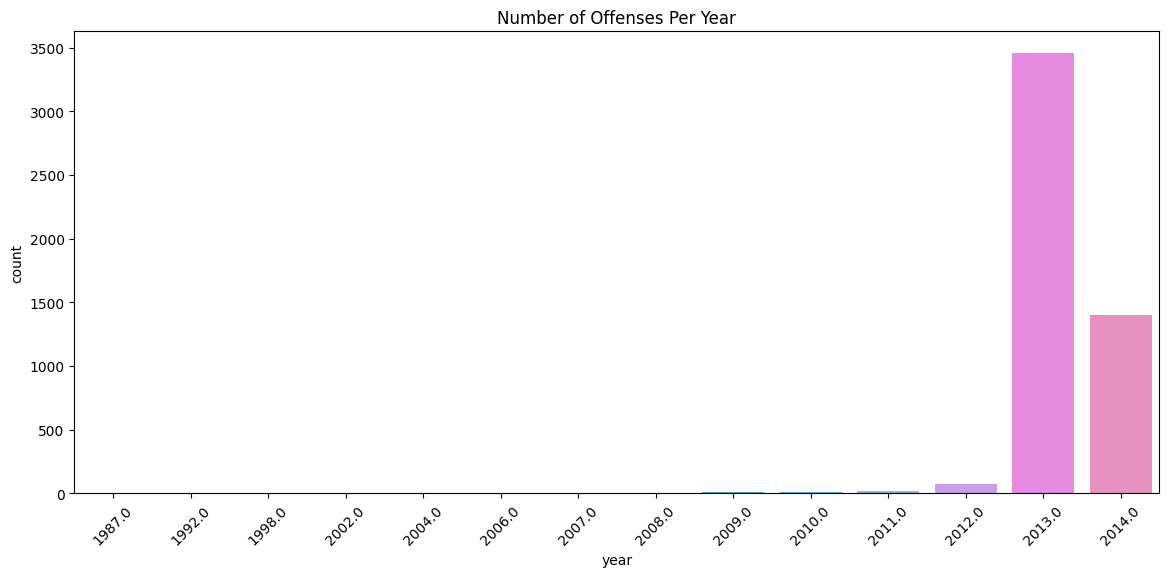

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


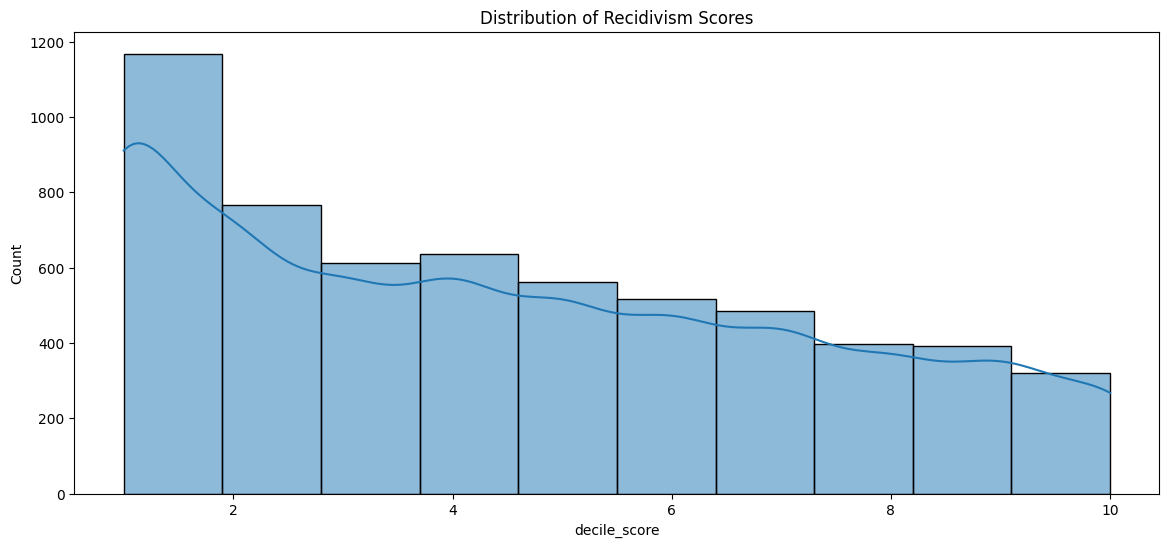

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


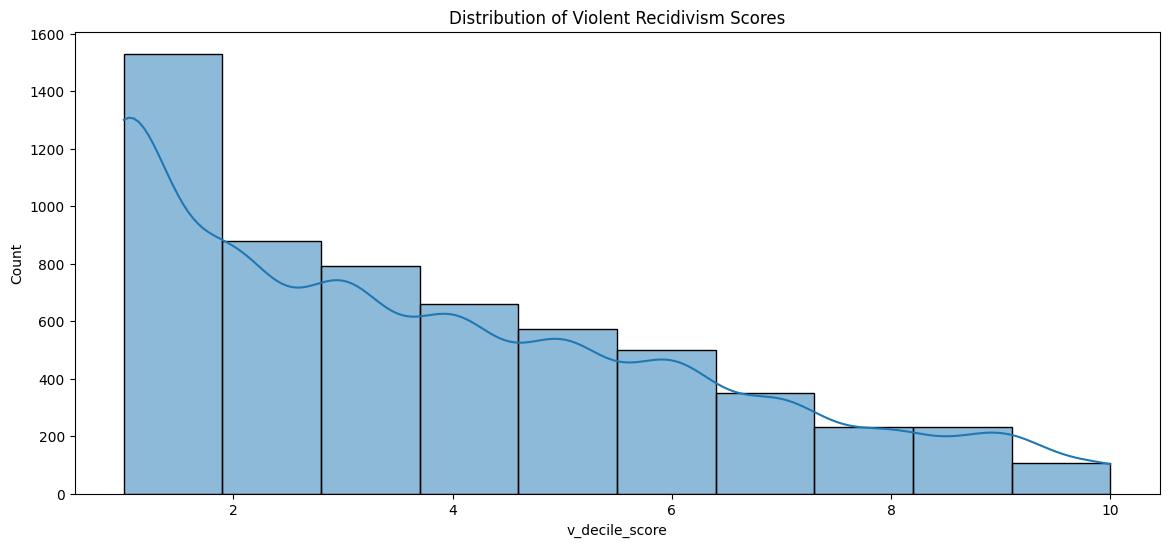

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

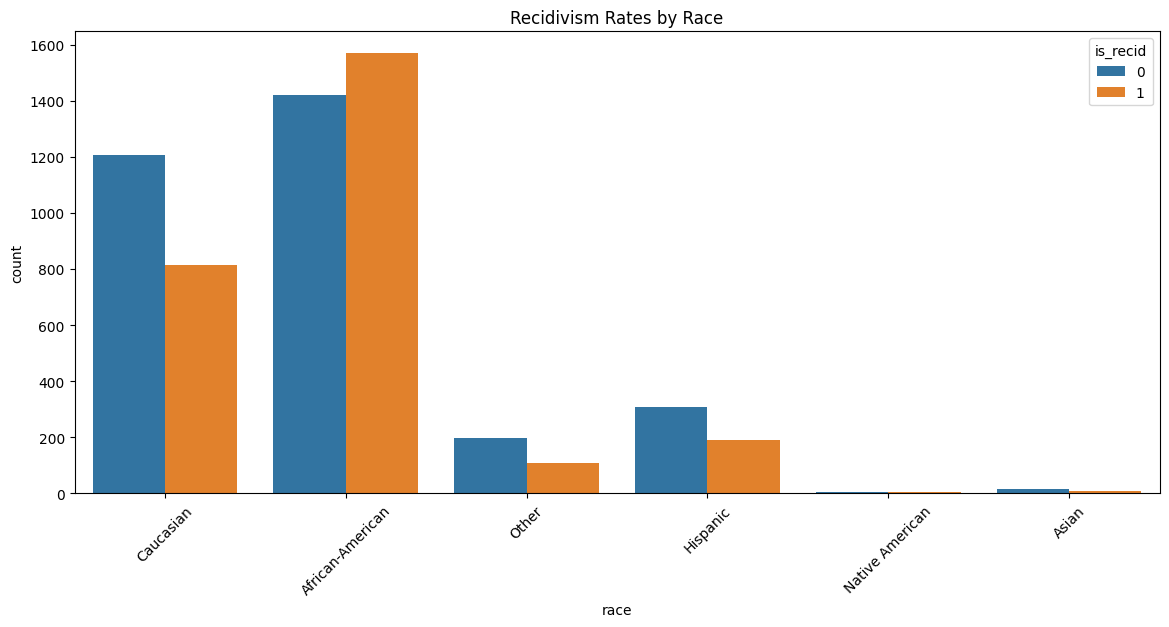

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

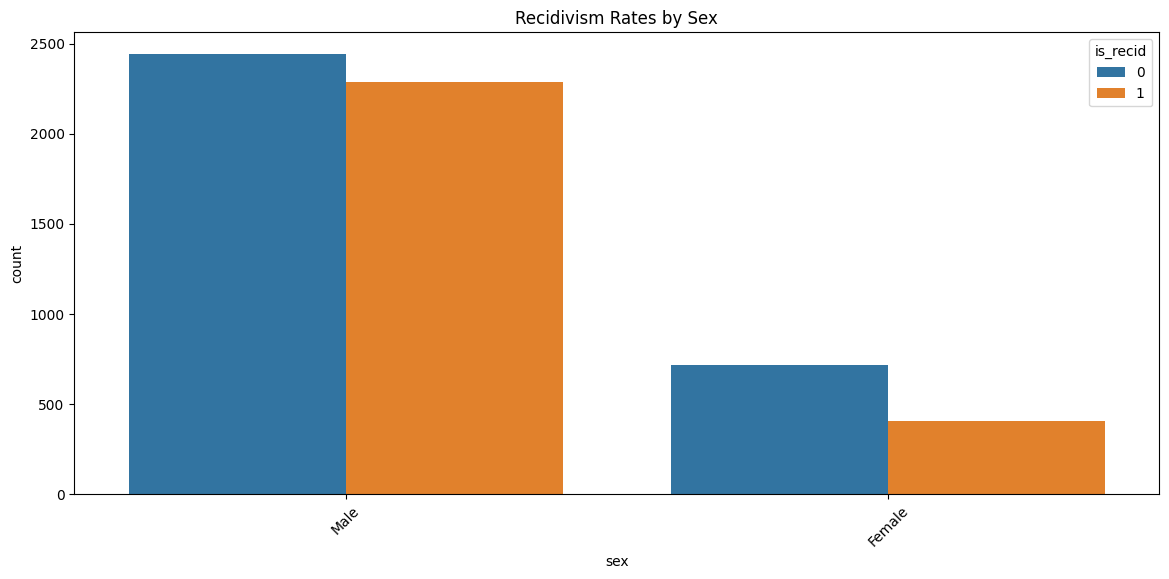

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


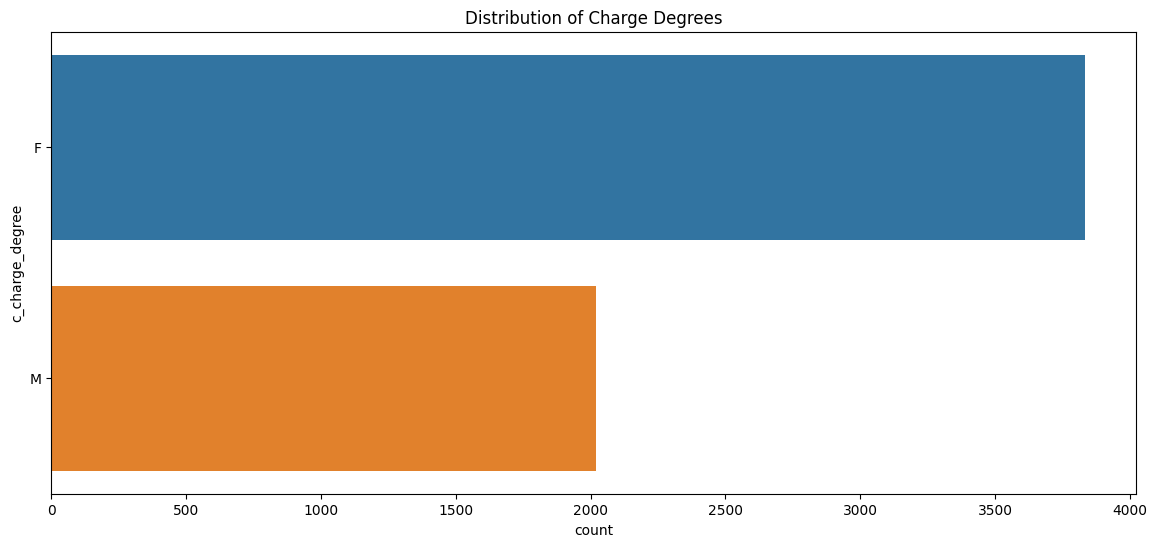

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


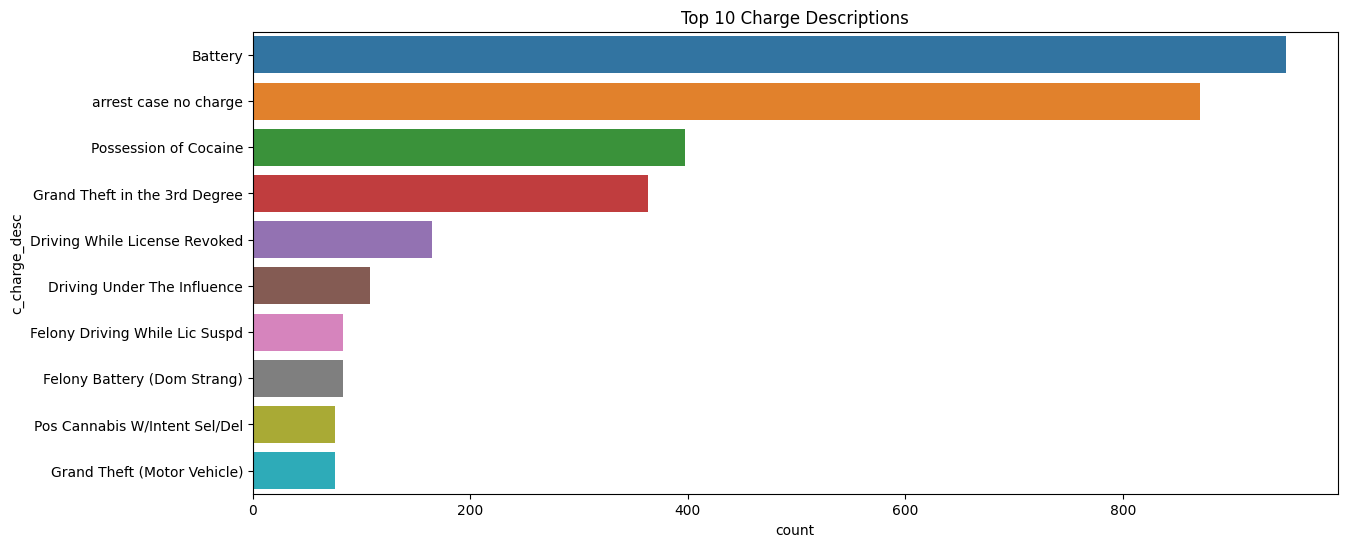

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


KeyError: 'is_recid'

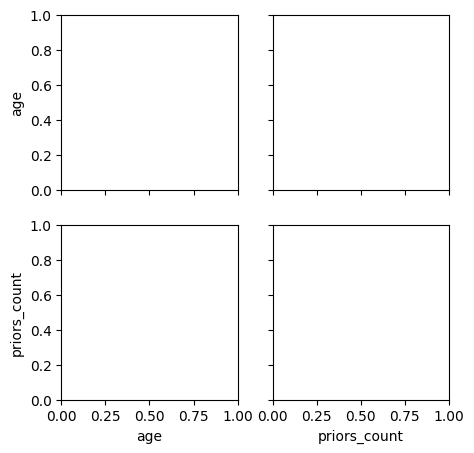

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.decomposition import PCA

# Convert dates to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])

# Time Series Analysis
plt.figure(figsize=(14, 6))
df['year'] = df['c_offense_date'].dt.year
sns.countplot(x='year', data=df)
plt.title('Number of Offenses Per Year')
plt.xticks(rotation=45)
plt.show()

# Distribution of Recidivism Scores
plt.figure(figsize=(14, 6))
sns.histplot(df['decile_score'], kde=True, bins=10)
plt.title('Distribution of Recidivism Scores')
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(df['v_decile_score'], kde=True, bins=10)
plt.title('Distribution of Violent Recidivism Scores')
plt.show()

# Demographic Analysis
plt.figure(figsize=(14, 6))
sns.countplot(x='race', hue='is_recid', data=df)
plt.title('Recidivism Rates by Race')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(x='sex', hue='is_recid', data=df)
plt.title('Recidivism Rates by Sex')
plt.xticks(rotation=45)
plt.show()

# Charge Degree and Description Analysis
plt.figure(figsize=(14, 6))
sns.countplot(y='c_charge_degree', data=df, order=df['c_charge_degree'].value_counts().index)
plt.title('Distribution of Charge Degrees')
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(y='c_charge_desc', data=df, order=df['c_charge_desc'].value_counts().index[:10])
plt.title('Top 10 Charge Descriptions')
plt.show()

# 8. Survival Analysis
#kmf = KaplanMeierFitter()
#T = (df['c_jail_out'] - df['c_jail_in']).dt.days
#E = df['is_recid']
#kmf.fit(T, event_observed=E)
#kmf.plot_survival_function()
#plt.title('Survival Analysis: Time until Recidivism')
#plt.xlabel('Days')
#plt.ylabel('Survival Probability')
#plt.show()

# 9. Pairplot
sns.pairplot(df[['age', 'priors_count']], hue='is_recid')
plt.show()

# 10. PCA
# Select numerical features and standardize them
X = df[numerical_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(14, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['is_recid'].dropna(), cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Recidivism Data')
plt.show()

##### END GPT

### EDA START

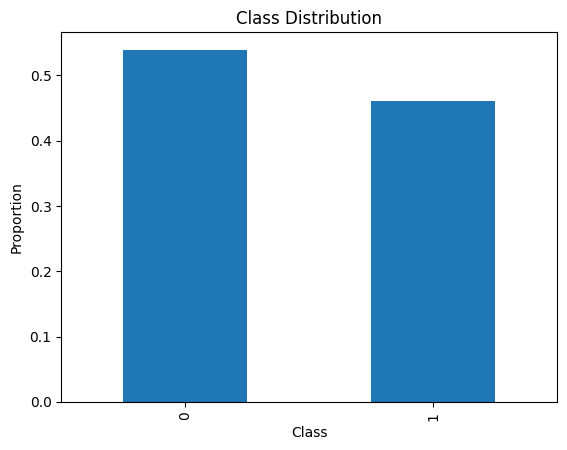

In [77]:
# Assuming 'target_column' is the name of the target variable column in your DataFrame
class_balance = df['is_recid'].value_counts(normalize=True)
class_balance.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Distribution')
plt.show()

In [54]:
df

,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,...,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid,offense_jail_duration
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,...,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,...,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,...,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1,264.0
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,...,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1,710.0
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,...,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6109,6110,seccunda davis,Male,1987-05-13,28,African-American,2013-08-18 07:25:24,2013-08-19 09:01:42,13015644MM10A,2013-08-18,...,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
6110,6111,mark montgomery,Male,1985-11-03,30,African-American,2013-03-23 01:32:34,2013-03-28 09:37:27,13005696MM10A,2013-03-23,...,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
6111,6112,erica johnson,Female,1982-06-23,33,Caucasian,2013-09-29 09:25:30,2013-09-30 09:59:37,13013661CF10A,2013-09-29,...,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN
6112,6113,barry williams,Male,1988-04-22,27,African-American,2013-10-30 03:40:14,2013-12-07 01:53:45,13004112MM10A,NaN,...,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN


## EDA

In [153]:
df.isnull().sum()

id                          0
name                        0
sex                         0
dob                         0
age                         0
race                        0
c_jail_in                 260
c_jail_out                260
c_case_number              18
c_offense_date            959
c_arrest_date            5173
c_charge_degree             0
c_charge_desc              24
juv_fel_count               0
juv_misd_count              0
juv_other_count             0
priors_count                0
compas_screening_date       0
type_of_assessment          0
decile_score                0
score_text                  0
v_type_of_assessment        0
v_decile_score              0
v_score_text                0
is_recid                    0
r_case_number            3183
r_offense_date           3183
r_charge_degree          3183
r_charge_desc            3232
is_violent_recid            0
vr_case_number           5420
vr_offense_date          5420
vr_charge_degree         5420
vr_charge_

In [86]:
df[['c_offense_date','c_arrest_date']]

,c_offense_date,c_arrest_date
0,2013-01-05,NaN
1,2013-04-02,NaN
2,2014-10-30,NaN
3,NaN,2014-01-23
4,2013-12-07,NaN
...,...,...
6109,2013-08-18,NaN
6110,2013-03-23,NaN
6111,2013-09-29,NaN
6112,NaN,2013-10-30


In [132]:
# Create a mask to identify rows where both c_offense_date and c_arrest_date are null
mask = (df['c_offense_date'].isnull() & df['c_arrest_date'].isnull())

# Filter the DataFrame to get only the rows where both columns are null
df_null_offense_arrest = df[mask]

print(df_null_offense_arrest[['c_offense_date','c_arrest_date']])

     c_offense_date c_arrest_date
127             NaT           NaT
1467            NaT           NaT
1638            NaT           NaT
2215            NaT           NaT
2360            NaT           NaT
2477            NaT           NaT
2545            NaT           NaT
2737            NaT           NaT
3010            NaT           NaT
3050            NaT           NaT
3901            NaT           NaT
4069            NaT           NaT
4192            NaT           NaT
4316            NaT           NaT
4340            NaT           NaT
5158            NaT           NaT
5388            NaT           NaT
5952            NaT           NaT


In [92]:
# Convert to datetime
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

# Calculate the differences
df['days_to_jail_from_offense'] = (df['c_offense_date']) - df['c_jail_in'] 
df['days_to_jail_from_arrest'] = (df['c_arrest_date']) - df['c_jail_in'] 

# Display summary statistics of the differences
offense_diff_summary = df['days_to_jail_from_offense'].describe()
arrest_diff_summary = df['days_to_jail_from_arrest'].describe()

print("Summary of days to jail from offense date:")
print(offense_diff_summary)
print("\nSummary of days to jail from arrest date:")
print(arrest_diff_summary)

Summary of days to jail from offense date:
count                            4983
mean     -33 days +11:18:50.009030705
std       266 days 16:05:02.307388384
min              -9485 days +16:01:38
25%          -1 days +12:31:18.500000
50%                 -1 days +16:07:30
75%                 -1 days +19:15:09
max                 299 days 19:06:45
Name: days_to_jail_from_offense, dtype: object

Summary of days to jail from arrest date:
count                              871
mean     -109 days +16:25:23.811710678
std        488 days 15:24:53.428958832
min               -5185 days +14:10:53
25%           -1 days +12:01:48.500000
50%                  -1 days +15:43:38
75%                  -1 days +20:21:49
max                  270 days 12:30:58
Name: days_to_jail_from_arrest, dtype: object


In [79]:
df.describe()

,id,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,v_decile_score,is_recid,is_violent_recid,two_year_recid
count,6114.000000,6114.000000,6114.000000,6114.000000,6114.000000,6114.000000,6114.000000,6114.000000,6114.000000,6114.000000,6114.000000
mean,3057.500000,34.757442,0.062643,0.090939,0.104351,3.438502,4.488878,3.688584,0.479392,0.113510,0.450114
std,1765.104105,11.802448,0.396906,0.486264,0.448095,4.858464,2.849050,2.503754,0.499616,0.317241,0.497546
min,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1529.250000,25.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,3057.500000,31.000000,0.000000,0.000000,0.000000,2.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,4585.750000,42.000000,0.000000,0.000000,0.000000,5.000000,7.000000,5.000000,1.000000,0.000000,1.000000
max,6114.000000,96.000000,10.000000,13.000000,9.000000,38.000000,10.000000,10.000000,1.000000,1.000000,1.000000


In [80]:
df.duplicated().sum()

0

In [81]:
df.index.duplicated().sum()

0

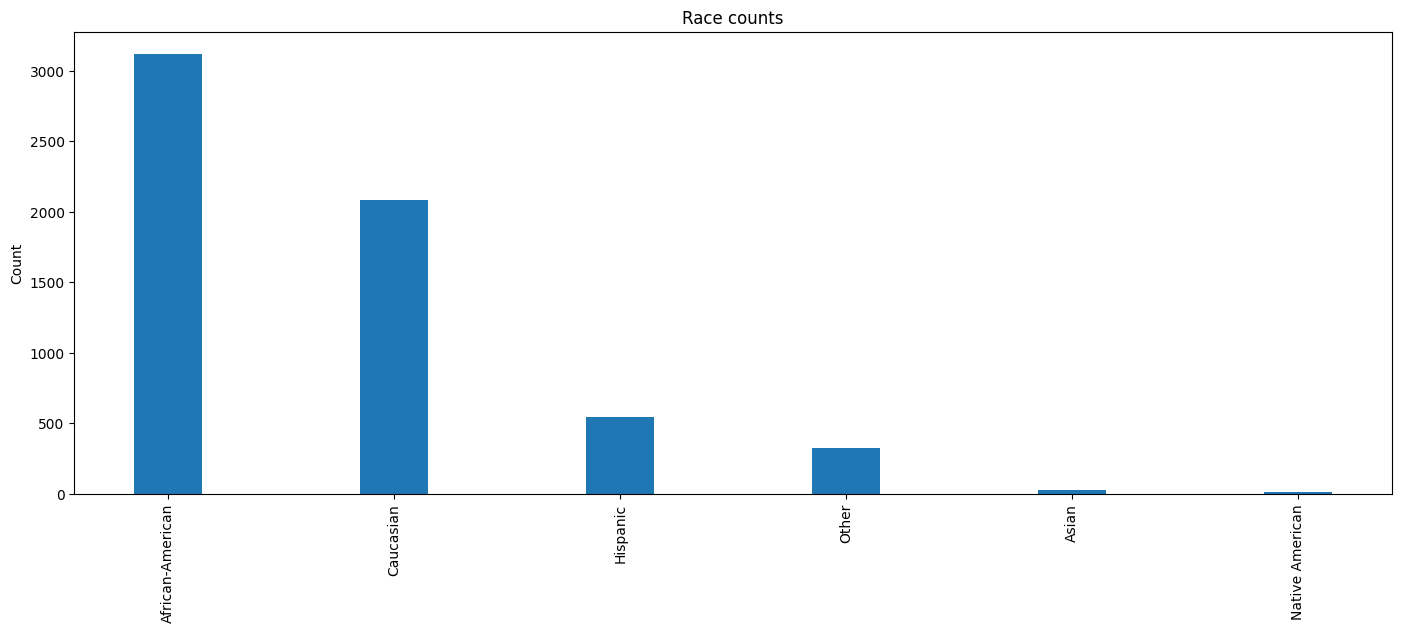

In [83]:
categories = df['race'].value_counts().index
counts = df['race'].value_counts().values
plt.figure(figsize=(17,6))
plt.title('Race counts')
plt.ylabel('Count')
plt.bar(categories, counts, width=0.3)
plt.xticks(rotation='vertical')
plt.show()

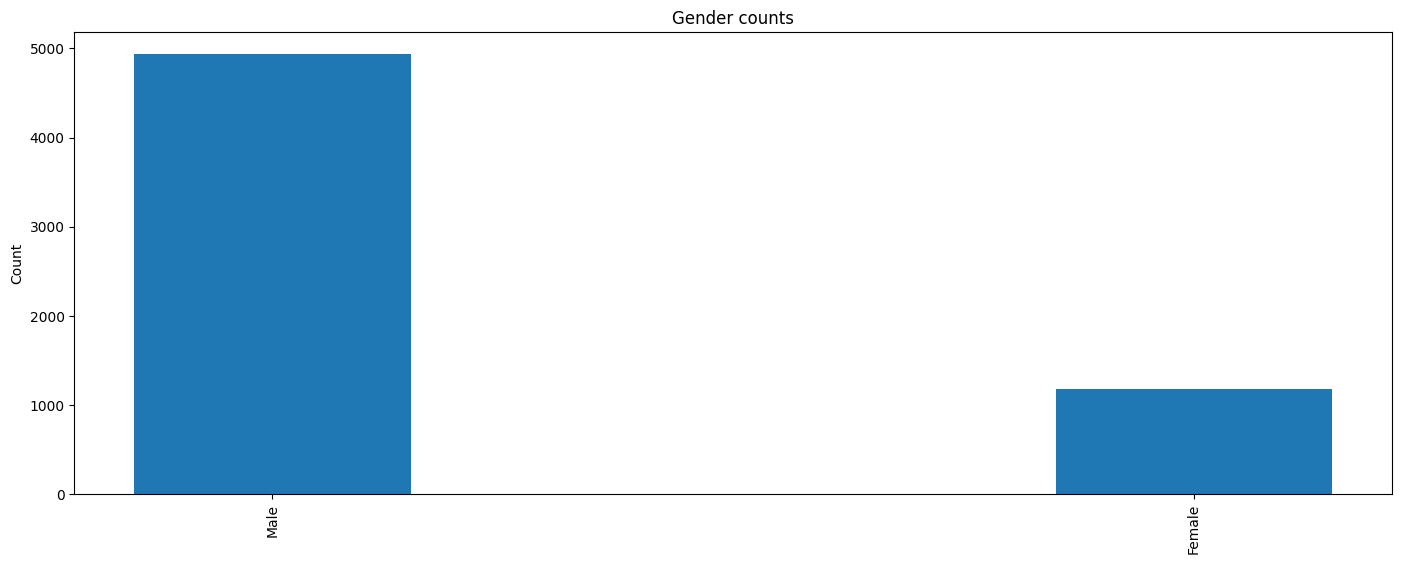

In [84]:
categories = df['sex'].value_counts().index
counts = df['sex'].value_counts().values
plt.figure(figsize=(17,6))
plt.title('Gender counts')
plt.ylabel('Count')
plt.bar(categories, counts, width=0.3)
plt.xticks(rotation='vertical')
plt.show()

/tmp/ipykernel_2385/3426792368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dob'] = pd.to_datetime(df['dob'])
/tmp/ipykernel_2385/3426792368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_birth'] = (pd.to_datetime('today') - df['dob']).dt.days // 365


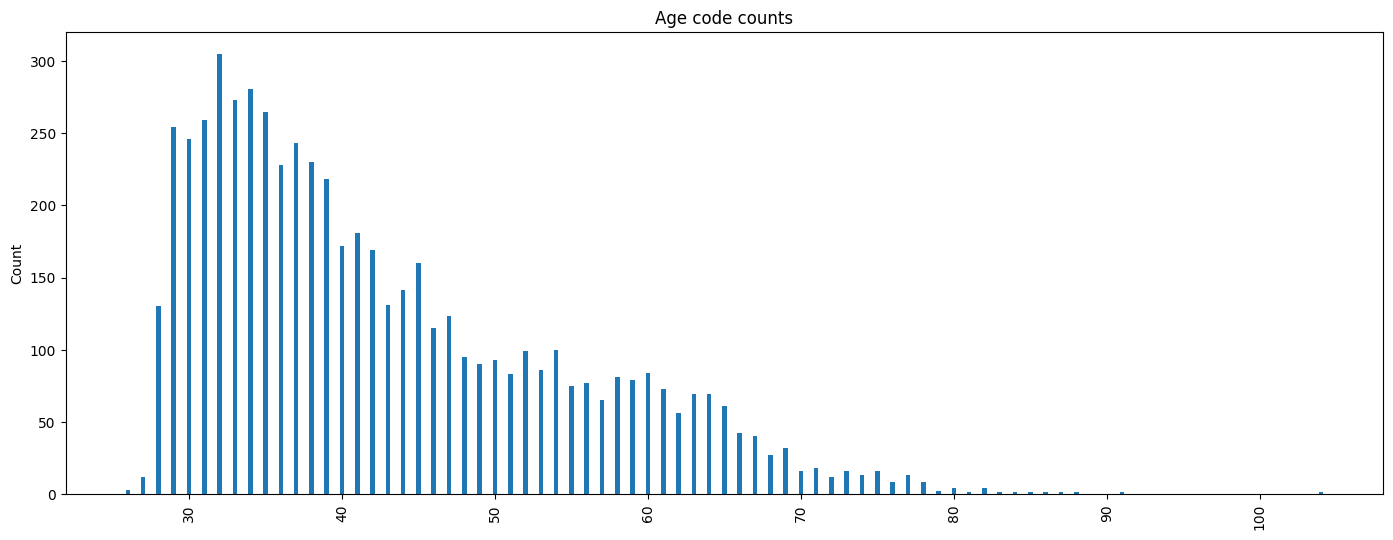

In [34]:
df['dob'] = pd.to_datetime(df['dob'])

df['age_birth'] = (pd.to_datetime('today') - df['dob']).dt.days // 365

categories = df['age_birth'].value_counts().index
counts = df['age_birth'].value_counts().values
plt.figure(figsize=(17,6))
plt.title('Age code counts')
plt.ylabel('Count')
plt.bar(categories, counts, width=0.3)
plt.xticks(rotation='vertical')
plt.show()

/tmp/ipykernel_93/1652332024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
/tmp/ipykernel_93/1652332024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
/tmp/ipykernel_93/1652332024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

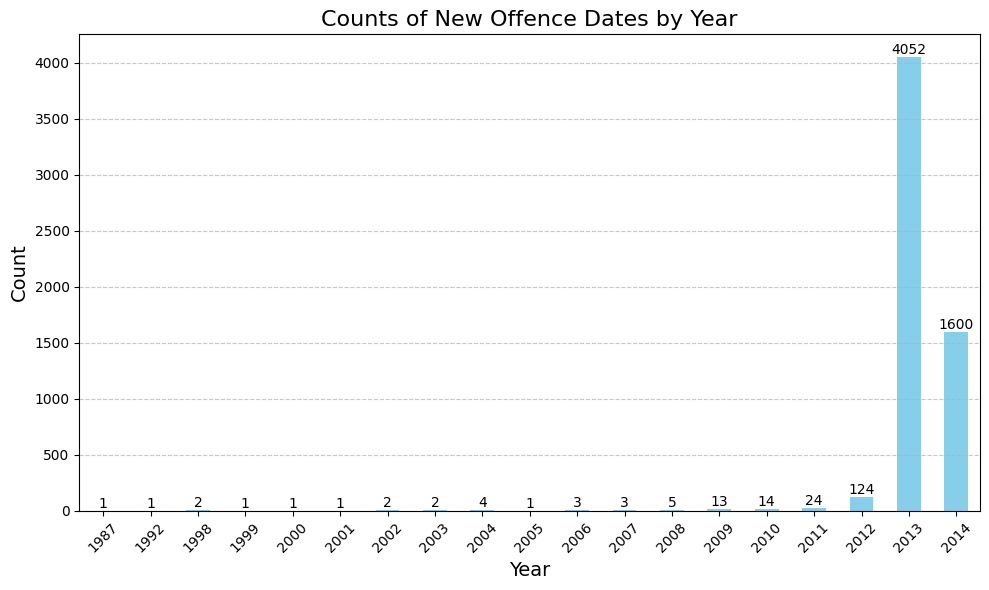

In [74]:
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])

df['new_offence_date'] = df['c_offense_date'].fillna(df['c_arrest_date'])
df.new_offence_date

# Extracting year from new_offence_date
df['year'] = df['new_offence_date'].dt.year

# Counting occurrences of each year
year_counts = df['year'].value_counts().sort_index()

# Plotting the counts by year
plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of New Offence Dates by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, count in enumerate(year_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()


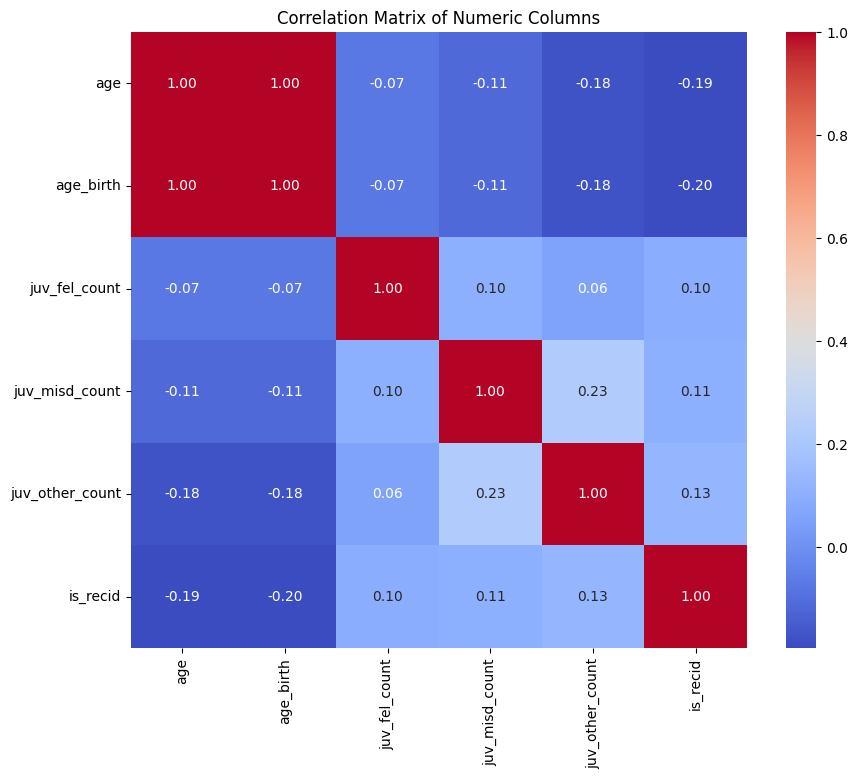

In [35]:
# Select numeric columns
numeric_columns = df[['age',
                      'age_birth',
                      'juv_fel_count',
                      'juv_misd_count',
                      'juv_other_count',
                      'is_recid']]

# Calculate correlation matrix
correlation_matrix = numeric_columns.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


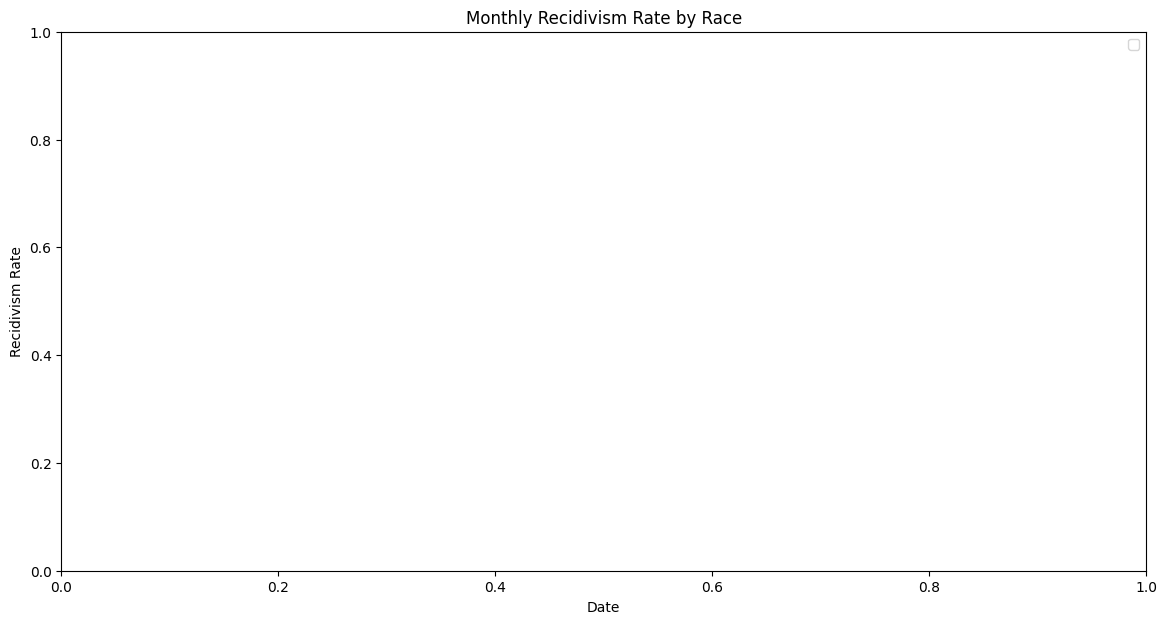

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


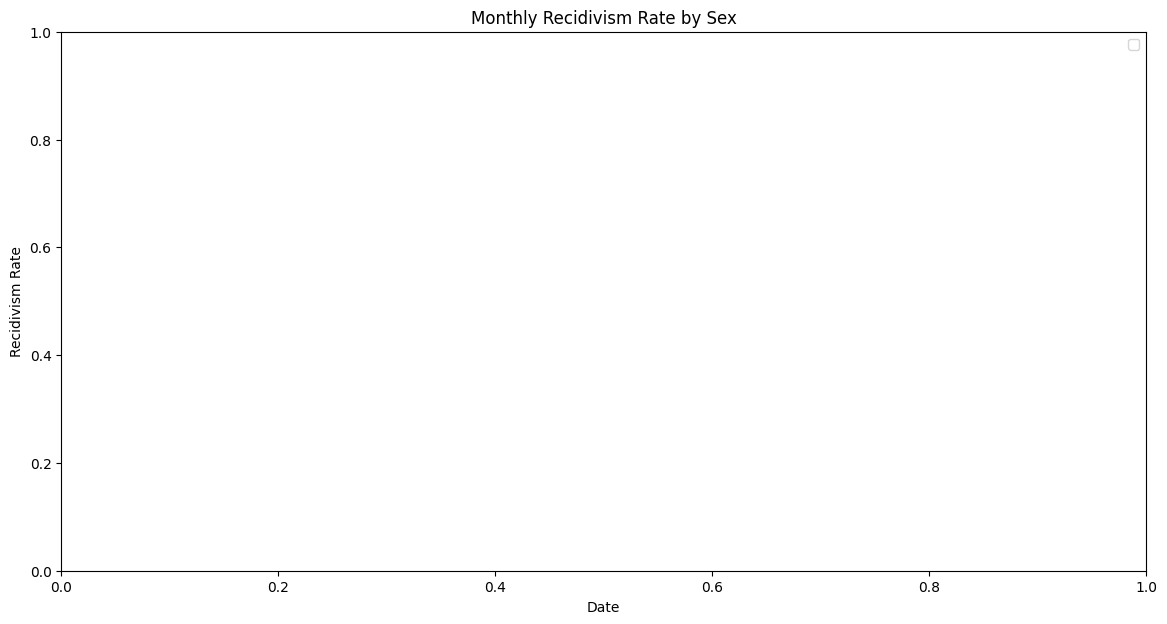

KeyError: 'age_group'

<Figure size 1400x700 with 0 Axes>

In [54]:
# Time-series analysis of recidivism by race
plt.figure(figsize=(14, 7))
for race in df['race'].unique():
    monthly_recid_race = df[df['race'] == race].resample('M', on='c_offense_date')['is_recid'].mean()
    monthly_recid_race.plot(label=race)
plt.title('Monthly Recidivism Rate by Race')
plt.ylabel('Recidivism Rate')
plt.xlabel('Date')
plt.legend()
plt.show()

# Time-series analysis of recidivism by sex
plt.figure(figsize=(14, 7))
for sex in df['sex'].unique():
    monthly_recid_sex = df[df['sex'] == sex].resample('M', on='c_offense_date')['is_recid'].mean()
    monthly_recid_sex.plot(label=sex)
plt.title('Monthly Recidivism Rate by Sex')
plt.ylabel('Recidivism Rate')
plt.xlabel('Date')
plt.legend()
plt.show()

# Time-series analysis of recidivism by age group
plt.figure(figsize=(14, 7))
for age_group in df['age_group'].unique():
    monthly_recid_age_group = df[df['age_group'] == age_group].resample('M', on='c_offense_date')['is_recid'].mean()
    monthly_recid_age_group.plot(label=age_group)
plt.title('Monthly Recidivism Rate by Age Group')
plt.ylabel('Recidivism Rate')
plt.xlabel('Date')
plt.legend()
plt.show()


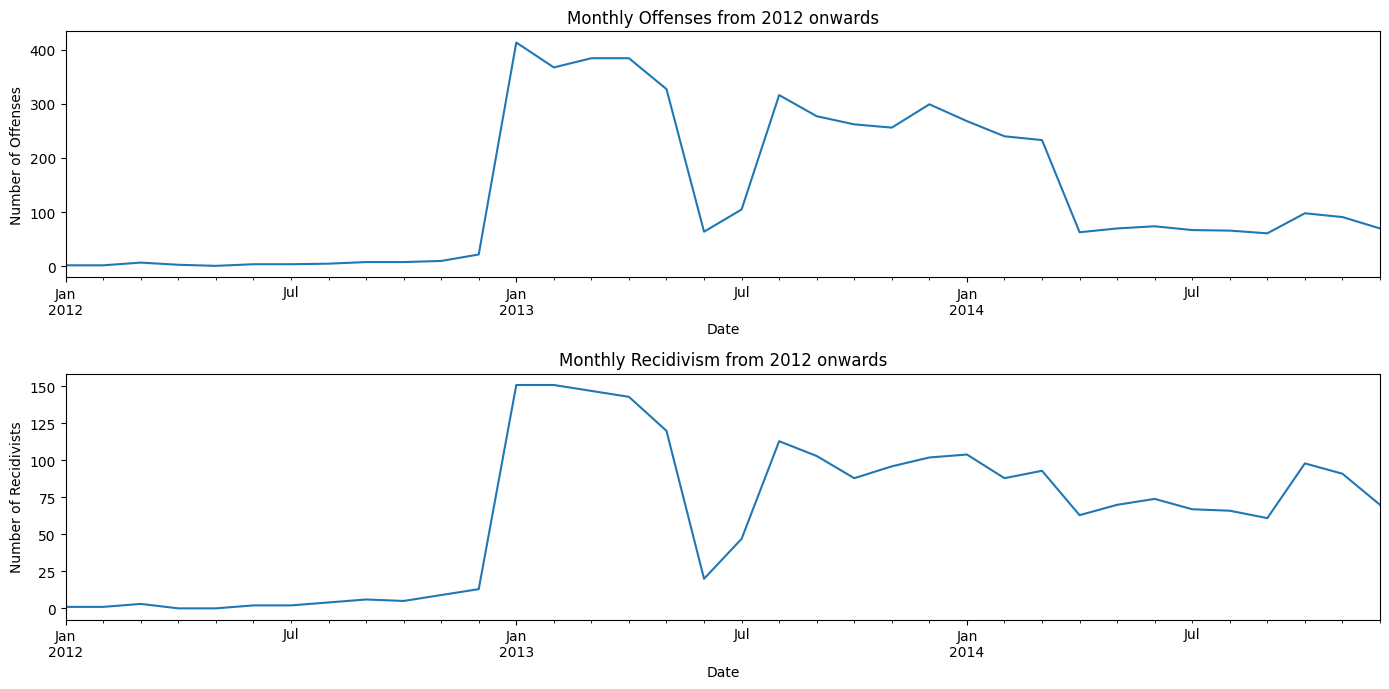

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has been preprocessed

# Filter the data to include only records from 2012 onwards
df = df[df['c_offense_date'] >= '2012-01-01']

# Ensure 'c_offense_date' is a datetime type
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])

# Resample to get monthly data for offenses and recidivism
monthly_offenses = df.resample('M', on='c_offense_date').size()
monthly_recid = df[df['is_recid'] == 1].resample('M', on='c_offense_date').size()

# Plot the monthly trends
plt.figure(figsize=(14, 7))

# 1st Graph: Monthly Offenses from 2012 onwards
plt.subplot(2, 1, 1)
monthly_offenses.plot()
plt.title('Monthly Offenses from 2012 onwards')
plt.ylabel('Number of Offenses')
plt.xlabel('Date')

# 3rd Graph: Monthly Recidivism from 2012 onwards
plt.subplot(2, 1, 2)
monthly_recid.plot()
plt.title('Monthly Recidivism from 2012 onwards')
plt.ylabel('Number of Recidivists')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

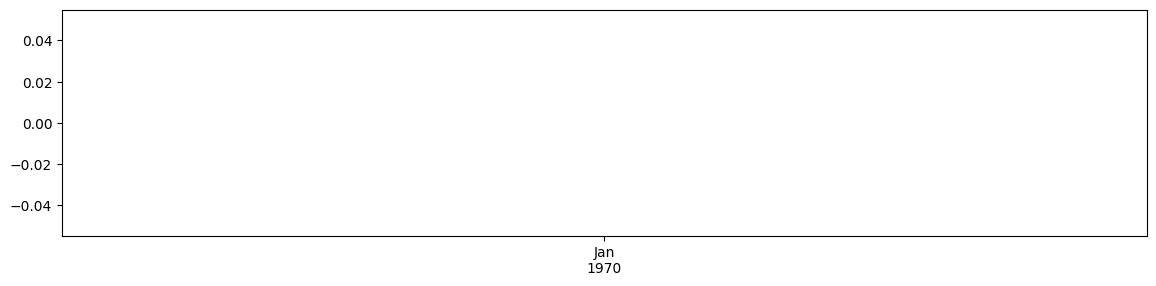

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load your dataset
# df = pd.read_csv('your_dataset.csv')  # Example loading method

# Ensure date columns are in datetime format and handle null values
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'], errors='coerce')
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'], errors='coerce')
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'], errors='coerce')

# Filter the data to include only records from 2012 onwards
df = df[df['c_offense_date'] >= '2012-01-01']

# Ensure your target column 'is_recid' is available and clean
df['is_recid'] = df['is_recid'].fillna(0).astype(int)

# Drop rows with invalid dates for the purpose of time series analysis
df = df.dropna(subset=['c_offense_date', 'c_arrest_date', 'c_jail_in'])

# Set the offense date as the index for resampling
df_offense = df.set_index('c_offense_date')
df_arrest = df.set_index('c_arrest_date')

# Aggregate data by month for offense dates
monthly_offenses = df_offense.resample('M').size()

# Aggregate data by month for arrests
monthly_arrests = df_arrest.resample('M').size()

# Aggregate data by month for recidivism
monthly_recid = df_offense[df_offense['is_recid'] == 1].resample('M').size()

# Handle any NaNs in the resampled series
monthly_offenses = monthly_offenses.fillna(0)
monthly_arrests = monthly_arrests.fillna(0)
monthly_recid = monthly_recid.fillna(0)

# Plot the monthly trends
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
monthly_offenses.plot()
plt.title('Monthly Offenses (2012 onwards)')
plt.ylabel('Number of Offenses')

plt.subplot(3, 1, 2)
monthly_arrests.plot()
plt.title('Monthly Arrests (2012 onwards)')
plt.ylabel('Number of Arrests')

plt.subplot(3, 1, 3)
monthly_recid.plot()
plt.title('Monthly Recidivism (2012 onwards)')
#plt.ylabel('Number of R


In [94]:
df[[ "id",
    "name",
    "sex",
    "dob",
    "race",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "c_case_number",
    "c_charge_degree",
    "c_charge_desc",
    "c_offense_date",
    "c_arrest_date",
    "c_jail_in",
    "c_jail_out",
    "age_birth",
    'is_recid']]

,id,name,sex,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_case_number,c_charge_degree,c_charge_desc,c_offense_date,c_arrest_date,c_jail_in,age_birth,is_recid
0,1,steven lux,Male,1953-06-15,Caucasian,0,0,0,0,13000208CF10A,F,False Imprisonment,2013-01-05,NaT,2013-01-05 04:35:31,71,0
1,2,andre small,Male,1987-10-01,African-American,0,0,0,1,13006354MM10A,M,Battery,2013-04-02,NaT,2013-04-02 12:18:46,36,0
2,3,willie gray,Male,1959-01-12,African-American,0,0,0,8,14040148MU10A,M,DUI Level 0.15 Or Minor In Veh,2014-10-30,NaT,2014-10-31 12:02:01,65,1
3,4,nickson marcellus,Male,1996-07-11,African-American,0,1,0,1,13017969CF10A,F,arrest case no charge,NaT,2014-01-23,2014-01-23 03:19:30,27,1
4,5,patria barnes,Female,1978-06-06,Other,0,0,0,0,13022717MM10A,M,Battery,2013-12-07,NaT,2013-12-08 01:55:28,46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6109,6110,seccunda davis,Male,1987-05-13,African-American,0,0,0,1,13015644MM10A,M,Battery,2013-08-18,NaT,2013-08-18 07:25:24,37,0
6110,6111,mark montgomery,Male,1985-11-03,African-American,0,0,0,4,13005696MM10A,M,Possess Cannabis/20 Grams Or Less,2013-03-23,NaT,2013-03-23 01:32:34,38,0
6111,6112,erica johnson,Female,1982-06-23,Caucasian,0,0,0,0,13013661CF10A,F,Felony Driving While Lic Suspd,2013-09-29,NaT,2013-09-29 09:25:30,42,0
6112,6113,barry williams,Male,1988-04-22,African-American,0,0,0,3,13004112MM10A,M,arrest case no charge,NaT,2013-10-30,2013-10-30 03:40:14,36,0


Text(0.5, 1.0, 'Distribution of priors_count')

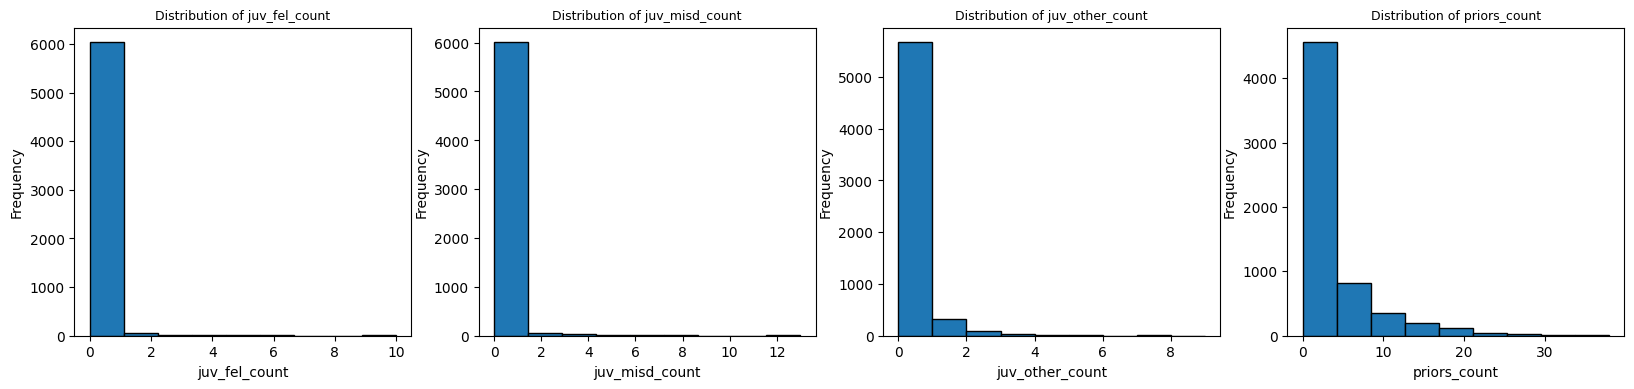

In [128]:
# Plotting histograms for each variable
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.hist(df['juv_fel_count'], bins=9, edgecolor='black')
plt.xlabel('juv_fel_count')
plt.ylabel('Frequency')
plt.title('Distribution of juv_fel_count',fontsize=9)

plt.subplot(1, 4, 2)
plt.hist(df['juv_misd_count'], bins=9, edgecolor='black')
plt.xlabel('juv_misd_count')
plt.ylabel('Frequency')
plt.title('Distribution of juv_misd_count',fontsize=9)

plt.subplot(1, 4, 3)
plt.hist(df['juv_other_count'], bins=9, edgecolor='black')
plt.xlabel('juv_other_count')
plt.ylabel('Frequency')
plt.title('Distribution of juv_other_count',fontsize=9)

plt.subplot(1, 4, 4)
plt.hist(df['priors_count'], bins=9, edgecolor='black')
plt.xlabel('priors_count')
plt.ylabel('Frequency')
plt.title('Distribution of priors_count',fontsize=9)

In [98]:
df['juv_misd_count'].max()

13

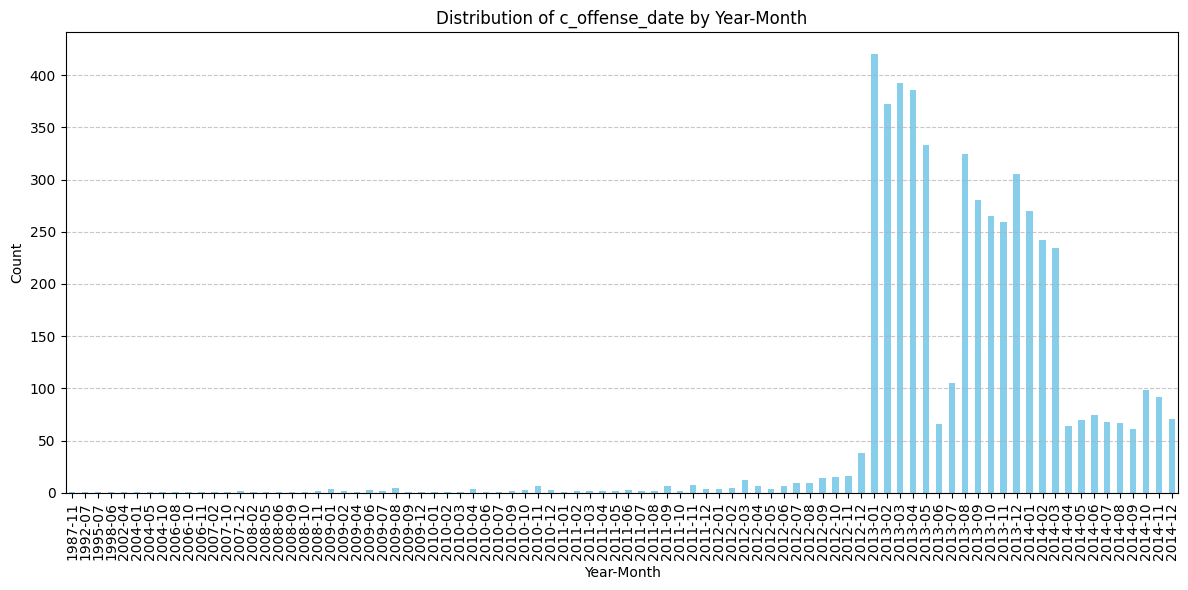

In [134]:
import pandas as pd
import matplotlib.pyplot as plt


df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])  # Convert to datetime

# Extract year and month
df['year_month'] = df['c_offense_date'].dt.to_period('M')

# Group by year_month and count occurrences
monthly_counts = df['year_month'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of c_offense_date by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')

# Decrease font size of x-axis tick labels
plt.xticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


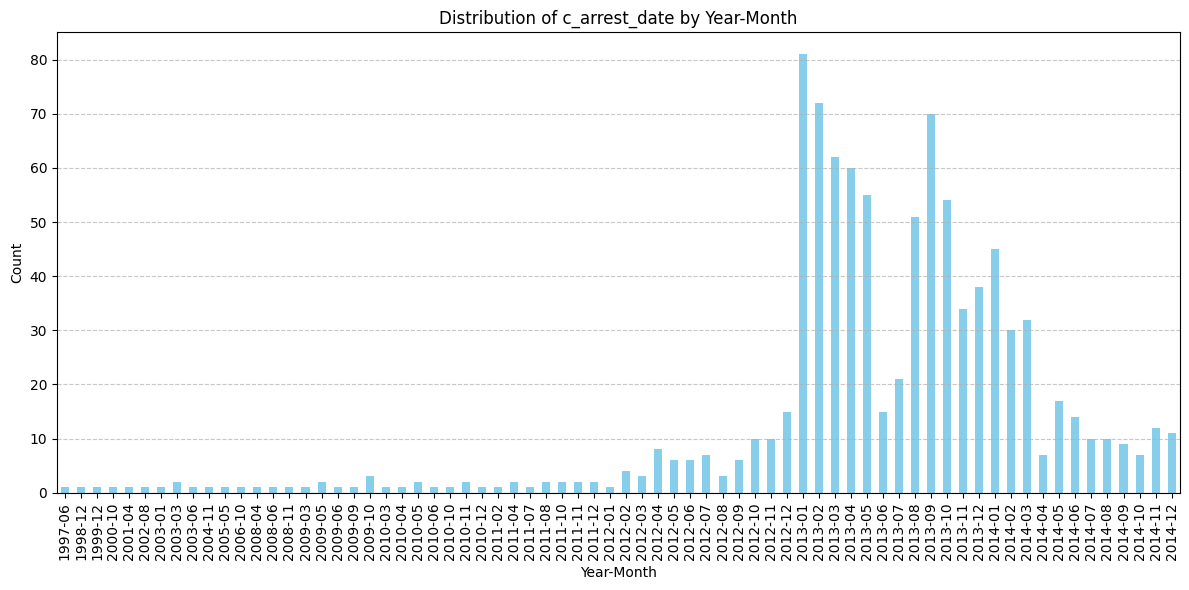

In [135]:
import pandas as pd
import matplotlib.pyplot as plt


df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])  # Convert to datetime

# Extract year and month
df['year_month'] = df['c_arrest_date'].dt.to_period('M')

# Group by year_month and count occurrences
monthly_counts = df['year_month'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of c_arrest_date by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')

# Decrease font size of x-axis tick labels
plt.xticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


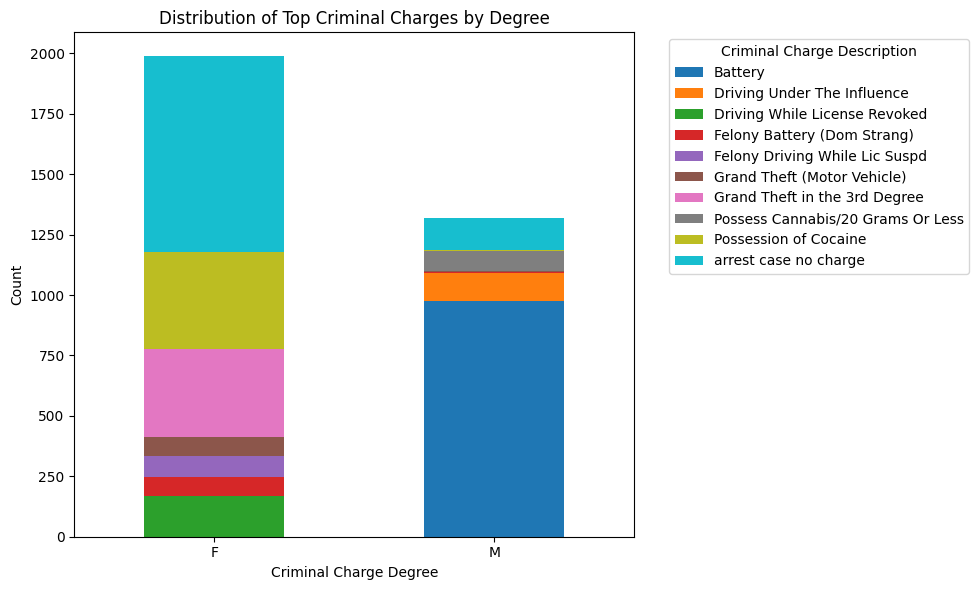

In [140]:
# Get top N most common c_charge_desc
top_n = 10  # Change to the number of top categories you want to include
top_desc = df['c_charge_desc'].value_counts().nlargest(top_n).index

# Filter DataFrame for top categories
df_top = df[df['c_charge_desc'].isin(top_desc)]

# Group by c_charge_degree and c_charge_desc and count occurrences
charge_counts = df_top.groupby(['c_charge_degree', 'c_charge_desc']).size().unstack(fill_value=0)

# Plotting
ax = charge_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Top Criminal Charges by Degree')
plt.xlabel('Criminal Charge Degree')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Move legend outside the plot
plt.legend(title='Criminal Charge Description', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [139]:
df.c_charge_desc.value_counts()

c_charge_desc
Battery                            977
arrest case no charge              941
Possession of Cocaine              406
Grand Theft in the 3rd Degree      367
Driving While License Revoked      168
                                  ... 
Deliver Alprazolam                   1
Poss Meth/Diox/Meth/Amp (MDMA)       1
Money Launder 100K or More Dols      1
Delivery Of Drug Paraphernalia       1
Offer Agree Secure For Lewd Act      1
Name: count, Length: 408, dtype: int64

In [144]:
# Count occurrences of each charge description
charge_desc_counts = df['c_charge_desc'].value_counts()

# Filter categories with less than 50 occurrences
charge_desc_counts_filtered = charge_desc_counts[charge_desc_counts > 50]
charge_desc_counts_filtered
## Plotting
#plt.figure(figsize=(10, 6))
#charge_desc_counts_filtered.plot(kind='bar')
#plt.title('Distribution of Criminal Charge Descriptions (Less than 50 occurrences)')
#plt.xlabel('Criminal Charge Description')
#plt.ylabel('Count')
#plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability
#plt.tight_layout()
#plt.show()

c_charge_desc
Battery                              977
arrest case no charge                941
Possession of Cocaine                406
Grand Theft in the 3rd Degree        367
Driving While License Revoked        168
Driving Under The Influence          115
Felony Battery (Dom Strang)           85
Felony Driving While Lic Suspd        85
Possess Cannabis/20 Grams Or Less     82
Grand Theft (Motor Vehicle)           79
Pos Cannabis W/Intent Sel/Del         78
Burglary Unoccupied Dwelling          70
Possession of Cannabis                63
Burglary Conveyance Unoccup           61
Poss3,4 Methylenedioxymethcath        59
Driving License Suspended             58
DUI Property Damage/Injury            58
Aggrav Battery w/Deadly Weapon        58
Felony Petit Theft                    55
Susp Drivers Lic 1st Offense          52
Name: count, dtype: int64

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


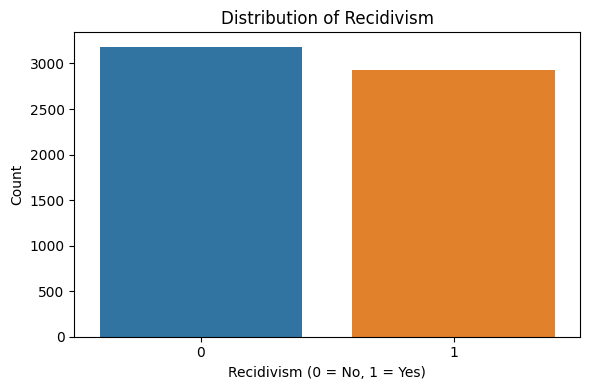

In [151]:
# Count occurrences of each category
recid_counts = df['is_recid'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=recid_counts.index, y=recid_counts.values)
plt.title('Distribution of Recidivism')
plt.xlabel('Recidivism (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [161]:
df = df.dropna(subset=['c_jail_out'])

# Suppose df_test has some different values, so we'll modify it directly
# Convert columns to datetime if they are not already
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])

df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])


#df.drop(columns=['two_year_recid'], inplace=True)
### Clean dataset to target variable

# Calculate the difference between 'r_offense_date' and 'c_jail_out'
df['offense_jail_duration'] = (df['r_offense_date'] - df['c_jail_out']).dt.days

# Create a new column based on your conditions
df['two_year_recid'] = ((df['is_recid'] == 1) & (df['offense_jail_duration'] <= 365 * 2)).astype(int)


/tmp/ipykernel_93/2097943873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_93/2097943873.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
/tmp/ipykernel_93/2097943873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [155]:
df['is_recid']=df['two_year_recid']

/tmp/ipykernel_93/1853513543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_recid']=df['two_year_recid']


/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


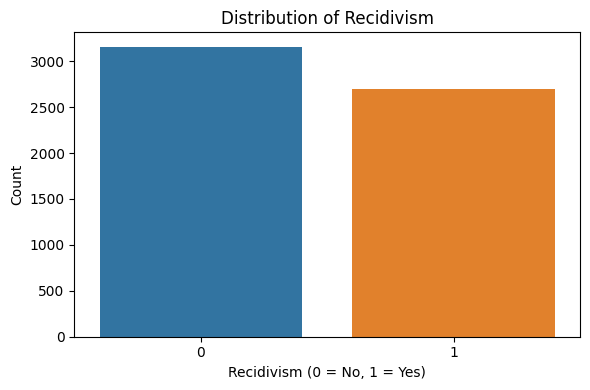

In [157]:
# Count occurrences of each category
recid_counts = df['is_recid'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=recid_counts.index, y=recid_counts.values)
plt.title('Distribution of Recidivism')
plt.xlabel('Recidivism (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [162]:
df.count()

id                       5854
name                     5854
sex                      5854
dob                      5854
age                      5854
race                     5854
c_jail_in                5854
c_jail_out               5854
c_case_number            5854
c_offense_date           4983
c_arrest_date             871
c_charge_degree          5854
c_charge_desc            5848
juv_fel_count            5854
juv_misd_count           5854
juv_other_count          5854
priors_count             5854
compas_screening_date    5854
type_of_assessment       5854
decile_score             5854
score_text               5854
v_type_of_assessment     5854
v_decile_score           5854
v_score_text             5854
is_recid                 5854
r_case_number            2879
r_offense_date           2879
r_charge_degree          2879
r_charge_desc            2830
is_violent_recid         5854
vr_case_number            681
vr_offense_date           681
vr_charge_degree          681
vr_charge_

In [ ]:
#non sense rows
df['invalid_jail_in_arrest'] = df['c_jail_in'] < df['c_arrest_date']
df['invalid_jail_in_offense'] = df['c_jail_in'] < df['c_offense_date']

In [164]:
import pandas as pd

# Convert 'c_jail_in' and 'c_jail_out' to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])

# Find cases where 'c_jail_out' is before 'c_jail_in'
invalid_cases = df[df['c_jail_out'] < df['c_jail_in']]

# Count the number of such cases
count_invalid_cases = len(invalid_cases)

print(f'Number of cases where c_jail_out is before c_jail_in: {count_invalid_cases}')


Number of cases where c_jail_out is before c_jail_in: 173


/tmp/ipykernel_93/335478747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_93/335478747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])


In [168]:
import pandas as pd

# Convert 'c_jail_in' and 'c_jail_out' to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])

# Find cases where 'c_jail_out' is before 'c_jail_in'
invalid_cases = df[df['c_jail_out'] < df['c_jail_in']]

# Calculate the difference in days for these cases
invalid_cases['days_difference'] = (invalid_cases['c_jail_in'] - invalid_cases['c_jail_out']).dt.days

# Display the number of such cases and the differences
count_invalid_cases = len(invalid_cases)
print(f'Number of cases where c_jail_out is before c_jail_in: {count_invalid_cases}')
print('Differences in days for these cases:')
print(invalid_cases['days_difference'].value_counts())


Number of cases where c_jail_out is before c_jail_in: 173
Differences in days for these cases:
days_difference
0    173
Name: count, dtype: int64


/tmp/ipykernel_93/4194971761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_93/4194971761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
/tmp/ipykernel_93/4194971761.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [170]:
# Convert 'c_jail_in' and 'c_jail_out' to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])

# Find cases where 'c_jail_out' is before 'c_jail_in'
invalid_cases = df[df['c_jail_in'] < df['c_arrest_date']]
print(invalid_cases[['id', 'c_jail_in', 'c_arrest_date']])

        id           c_jail_in c_arrest_date
192    193 2013-07-29 09:57:48    2013-08-13
208    209 2013-04-16 11:48:03    2013-04-17
212    213 2013-08-06 08:24:10    2013-08-07
221    222 2013-09-16 06:36:09    2013-09-17
245    246 2014-01-06 07:12:43    2014-01-07
...    ...                 ...           ...
5683  5684 2013-08-01 09:47:30    2013-08-27
5732  5733 2013-12-26 01:41:36    2014-01-31
5762  5763 2013-01-10 09:02:17    2013-01-11
5789  5790 2013-10-22 08:38:06    2013-10-23
6085  6086 2013-02-05 11:27:02    2013-02-06

[83 rows x 3 columns]


/tmp/ipykernel_93/2679025438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_93/2679025438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])


In [174]:
# Convert 'c_jail_in' and 'c_jail_out' to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])

# Find cases where 'c_jail_out' is before 'c_jail_in'
invalid_cases = df[df['c_jail_in'] < df['c_offense_date']]
print(invalid_cases[['id', 'c_jail_in', 'c_offense_date']])


        id           c_jail_in c_offense_date
252    253 2013-07-22 06:17:17     2013-11-04
467    468 2013-09-19 02:37:27     2013-12-30
841    842 2013-11-02 05:23:27     2014-01-13
1056  1057 2013-05-08 04:53:15     2014-03-04
1282  1283 2013-03-19 12:47:07     2013-03-20
2060  2061 2014-02-24 05:11:22     2014-02-25
2255  2256 2013-07-19 04:09:36     2013-08-27
2473  2474 2013-12-05 01:07:45     2013-12-08
2543  2544 2013-04-10 05:59:23     2013-04-11
2672  2673 2013-03-05 04:57:56     2013-03-11
2749  2750 2013-03-05 08:54:54     2013-03-07
2762  2763 2013-01-07 04:19:44     2013-04-30
3036  3037 2013-02-05 05:29:49     2013-02-27
3091  3092 2014-06-08 08:36:51     2014-08-23
3192  3193 2014-08-21 06:34:44     2014-08-22
3856  3857 2014-09-16 03:26:15     2014-09-17
3913  3914 2014-03-29 02:59:33     2014-03-31
3959  3960 2013-07-10 07:07:35     2013-07-29
3971  3972 2014-06-26 12:30:39     2014-08-02
4080  4081 2013-04-24 08:00:35     2013-04-25
4177  4178 2014-12-16 01:46:57    

/tmp/ipykernel_93/2120619147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_93/2120619147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])


In [16]:
import pandas as pd

# Convert dates to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])

# Swap c_jail_in and c_jail_out where c_jail_out is before c_jail_in and the difference is less than one day
swap_mask = (df['c_jail_out'] < df['c_jail_in']) & ((df['c_jail_in'] - df['c_jail_out']).dt.days < 1)
df.loc[swap_mask, ['c_jail_in', 'c_jail_out']] = df.loc[swap_mask, ['c_jail_out', 'c_jail_in']].values

# Flagging invalid data
df['invalid_jail_out'] = df['c_jail_out'] < df['c_jail_in']
df['invalid_jail_in_arrest'] = df['c_jail_in'] < df['c_arrest_date']
df['invalid_jail_in_offense'] = df['c_jail_in'] < df['c_offense_date']

# Print counts of invalid cases for reporting
invalid_jail_out_count = df['invalid_jail_out'].sum()
invalid_jail_in_arrest_count = df['invalid_jail_in_arrest'].sum()
invalid_jail_in_offense_count = df['invalid_jail_in_offense'].sum()

print(f'Number of cases where c_jail_out is before c_jail_in: {invalid_jail_out_count}')
print(f'Number of cases where c_jail_in is before c_arrest_date: {invalid_jail_in_arrest_count}')
print(f'Number of cases where c_jail_in is before c_offense_date: {invalid_jail_in_offense_count}')

# Remove rows with invalid jail_in dates before arrest_date or offense_date
df_cleaned = df[~(df['invalid_jail_in_arrest'] | df['invalid_jail_in_offense'])]

# Optionally, drop the flag columns if no longer needed
df_cleaned = df_cleaned.drop(columns=['invalid_jail_out', 'invalid_jail_in_arrest', 'invalid_jail_in_offense'])



Number of cases where c_jail_out is before c_jail_in: 0
Number of cases where c_jail_in is before c_arrest_date: 83
Number of cases where c_jail_in is before c_offense_date: 31


/tmp/ipykernel_2385/2624566894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
/tmp/ipykernel_2385/2624566894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
/tmp/ipykernel_2385/2624566894.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

## Business Question

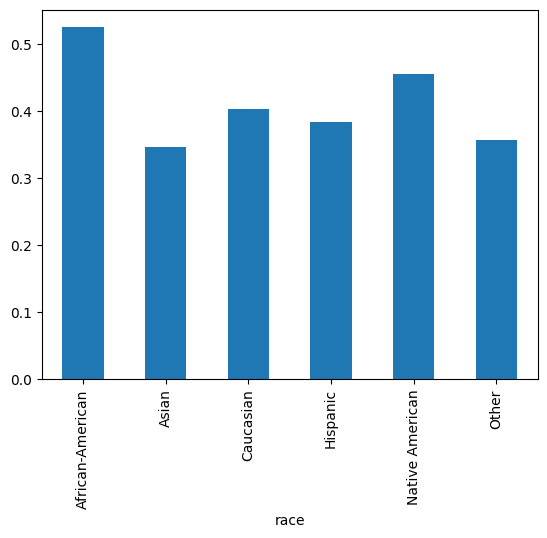

In [205]:
df.groupby('race')['is_recid'].mean().plot(kind='bar')
plt.show()

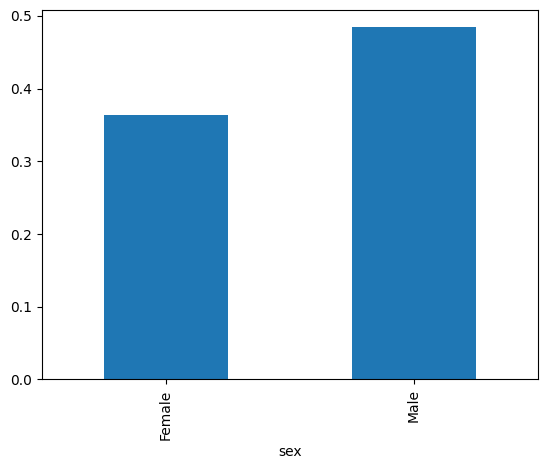

In [206]:
df.groupby('sex')['two_year_recid'].mean().plot(kind='bar')
plt.show()

In [208]:
#df.groupby('age_birth')['two_year_recid'].mean().plot(kind='bar')
#plt.show()

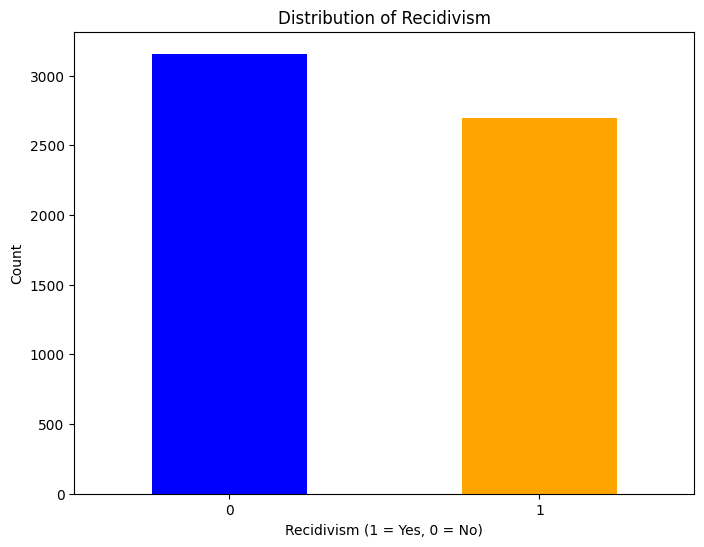

In [27]:
# Plot the is_recid column
plt.figure(figsize=(8, 6))
df['is_recid'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Recidivism')
plt.xlabel('Recidivism (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Chi-square test for age group and recidivism: p-value=2.1011442815668287e-37


/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

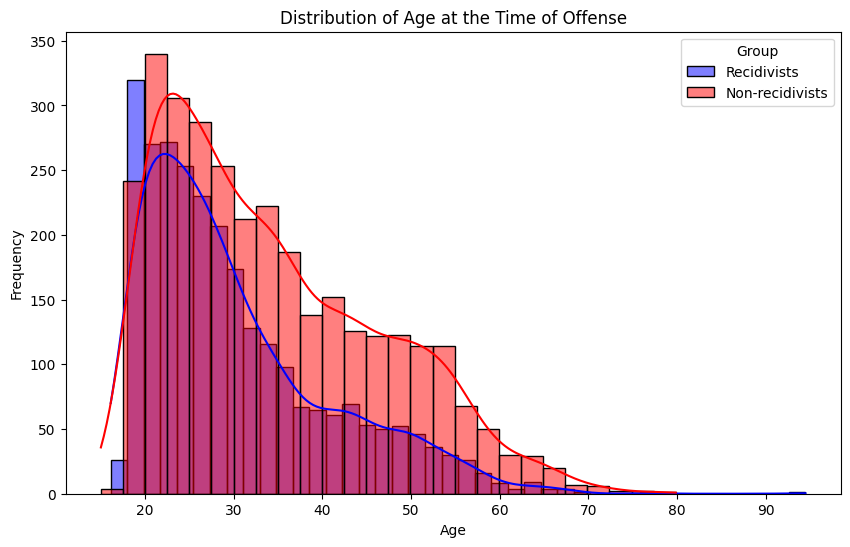

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


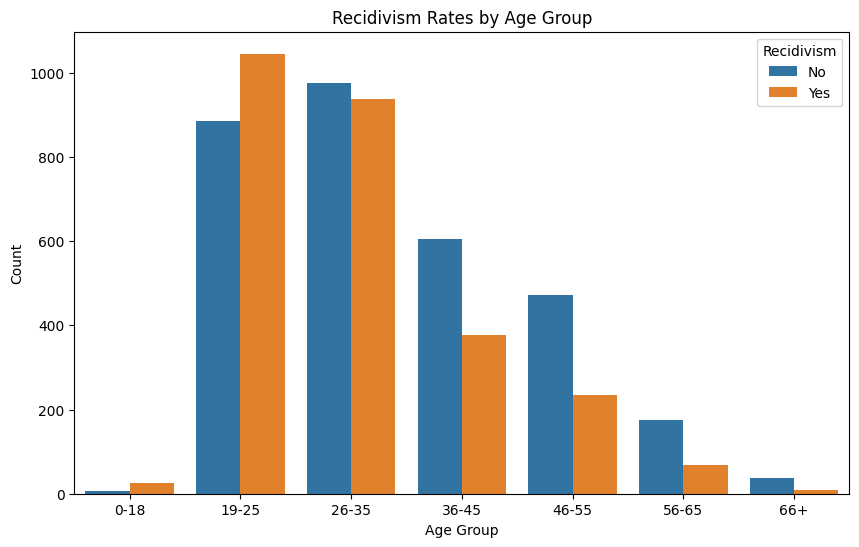

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

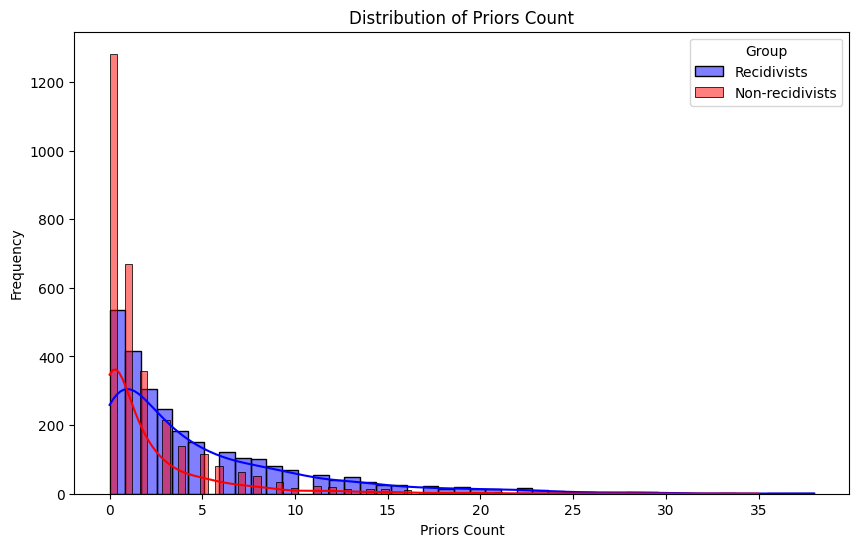

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

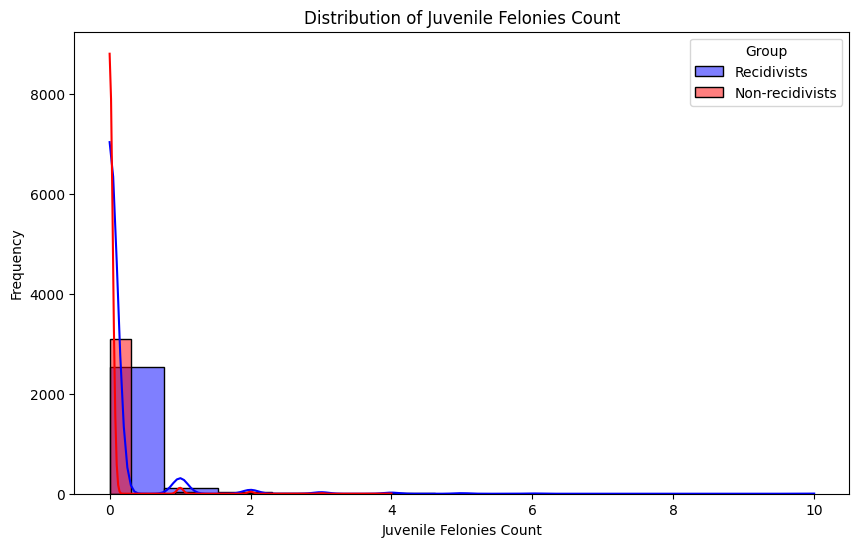

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

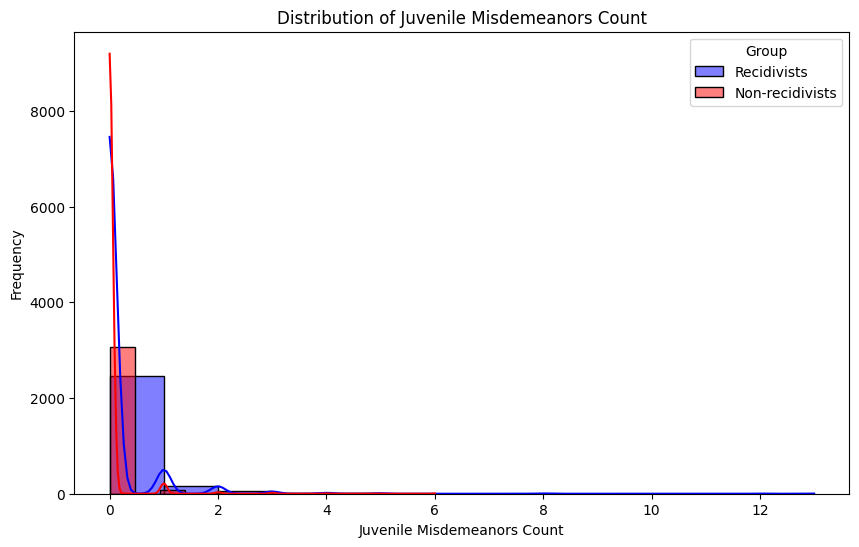

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

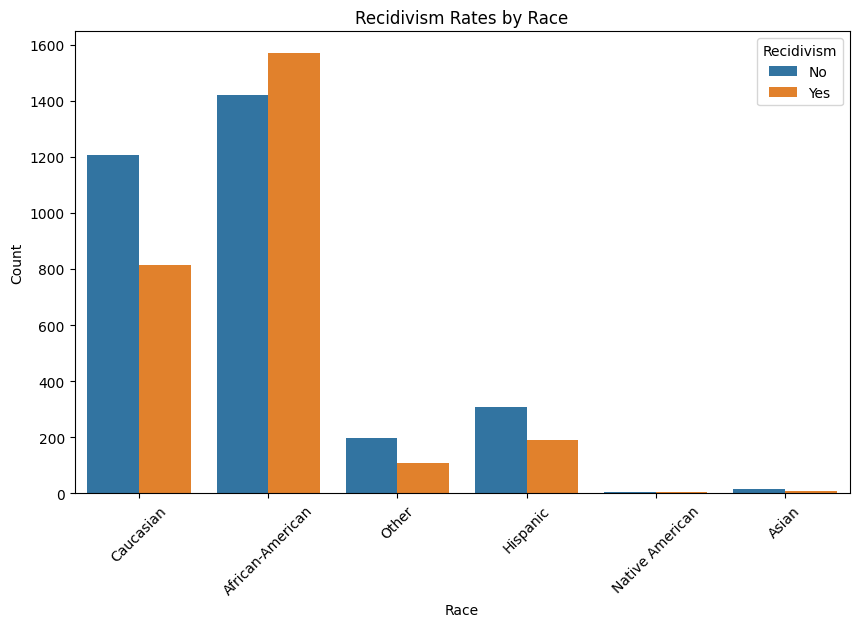

Chi-square test for race and recidivism: p-value=1.0035697250320246e-20


/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

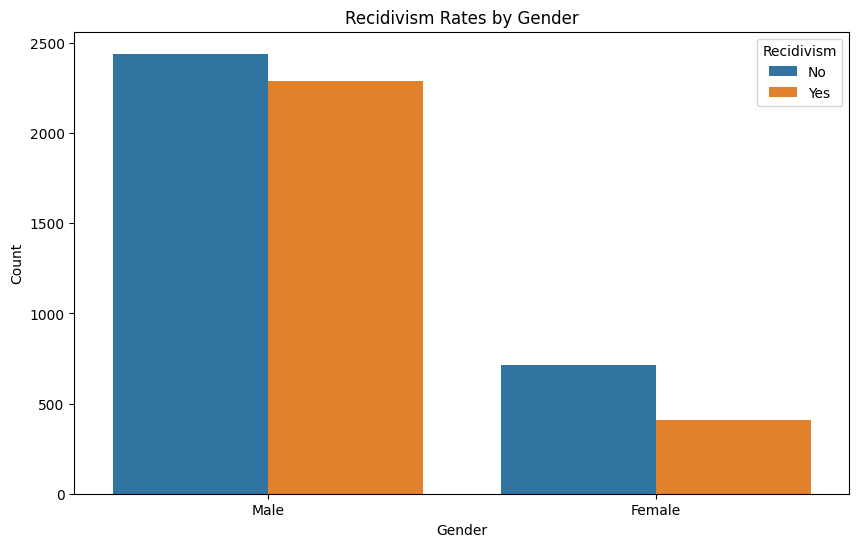

Chi-square test for gender and recidivism: p-value=3.367240690133213e-13


/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

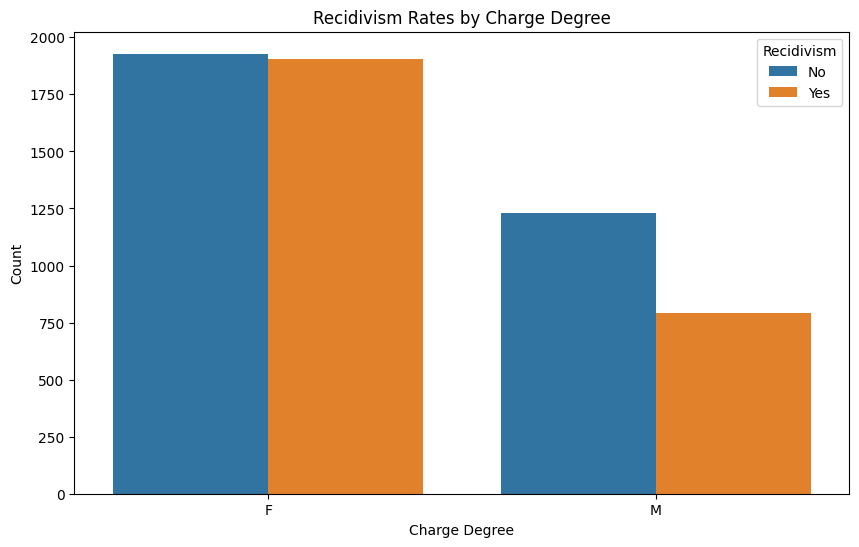

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

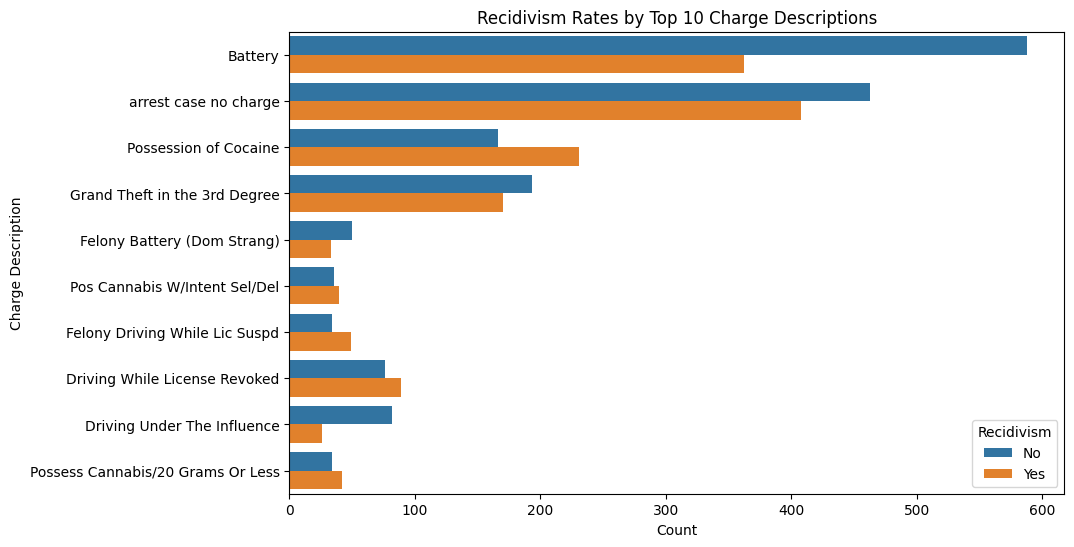

/tmp/ipykernel_93/1609877306.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_r['time_to_recidivism'] = (df_cleaned_r['r_offense_date'] - df_cleaned_r['c_jail_in']).dt.days


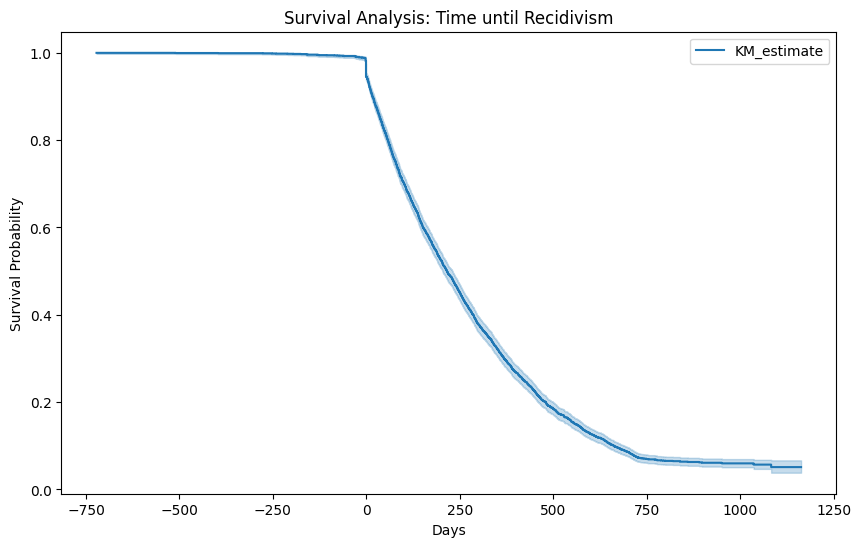

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


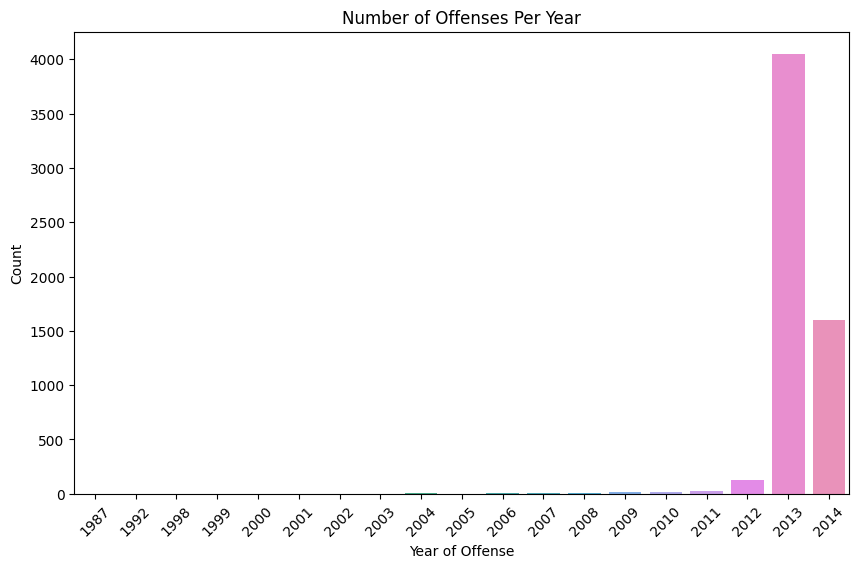

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter


#df['new_offence_date'] = df['c_offense_date'].fillna(df['c_arrest_date'])


# Convert dates to datetime
df['dob'] = pd.to_datetime(df['dob'])
df['new_offence_date'] = pd.to_datetime(df['new_offence_date'])
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

# Keep only the relevant columns
required_columns = ['id', 'name', 'sex', 'dob', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                    'c_case_number', 'c_charge_degree', 'c_charge_desc', 'new_offence_date', 'r_offense_date','c_jail_in', 'is_recid']
df = df[required_columns]

df_cleaned=df
# 1. Characteristics of Recidivists

# Age at the time of offense

# Calculate age at the time of offense
df_cleaned['age_at_offense'] = (df_cleaned['new_offence_date'] - df_cleaned['dob']).dt.days / 365.25

# Bin the age variable into categories
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
df_cleaned['age_group'] = pd.cut(df_cleaned['age_at_offense'], bins=bins, labels=labels, right=False)

# Chi-square test for age group and recidivism
age_recid_crosstab = pd.crosstab(df_cleaned['age_group'], df_cleaned['is_recid'])
chi2, p, _, _ = chi2_contingency(age_recid_crosstab)
print(f'Chi-square test for age group and recidivism: p-value={p}')

# Plotting the distribution of age at the time of offense
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 1]['age_at_offense'], kde=True, color='blue', label='Recidivists')
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 0]['age_at_offense'], kde=True, color='red', label='Non-recidivists')
plt.title('Distribution of Age at the Time of Offense')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(title='Group')
plt.show()


# Recidivism Rates by Age Group
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='is_recid', data=df_cleaned)
plt.title('Recidivism Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Recidivism', labels=['No', 'Yes'])
plt.show()

# Priors count
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 1]['priors_count'], kde=True, color='blue', label='Recidivists')
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 0]['priors_count'], kde=True, color='red', label='Non-recidivists')
plt.title('Distribution of Priors Count')
plt.xlabel('Priors Count')
plt.ylabel('Frequency')
plt.legend(title='Group')
plt.show()

# Juvenile felonies and misdemeanors
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 1]['juv_fel_count'], kde=True, color='blue', label='Recidivists')
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 0]['juv_fel_count'], kde=True, color='red', label='Non-recidivists')
plt.title('Distribution of Juvenile Felonies Count')
plt.xlabel('Juvenile Felonies Count')
plt.ylabel('Frequency')
plt.legend(title='Group')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 1]['juv_misd_count'], kde=True, color='blue', label='Recidivists')
sns.histplot(df_cleaned[df_cleaned['is_recid'] == 0]['juv_misd_count'], kde=True, color='red', label='Non-recidivists')
plt.title('Distribution of Juvenile Misdemeanors Count')
plt.xlabel('Juvenile Misdemeanors Count')
plt.ylabel('Frequency')
plt.legend(title='Group')
plt.show()

# 2. Recidivism Rates by Race and Gender

# Race
plt.figure(figsize=(10, 6))
sns.countplot(x='race', hue='is_recid', data=df_cleaned)
plt.title('Recidivism Rates by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Recidivism', labels=['No', 'Yes'])
plt.xticks(ticks=range(len(df_cleaned['race'].unique())), labels=df_cleaned['race'].unique(), rotation=45)
plt.show()

# Chi-square test for race and recidivism
race_recid_crosstab = pd.crosstab(df_cleaned['race'], df_cleaned['is_recid'])
chi2, p, _, _ = chi2_contingency(race_recid_crosstab)
print(f'Chi-square test for race and recidivism: p-value={p}')

# Gender
plt.figure(figsize=(10, 6))
sns.countplot(x='sex', hue='is_recid', data=df_cleaned)
plt.title('Recidivism Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Recidivism', labels=['No', 'Yes'])
plt.xticks(ticks=range(len(df_cleaned['sex'].unique())), labels=df_cleaned['sex'].unique())
plt.show()

# Chi-square test for gender and recidivism
gender_recid_crosstab = pd.crosstab(df_cleaned['sex'], df_cleaned['is_recid'])
chi2, p, _, _ = chi2_contingency(gender_recid_crosstab)
print(f'Chi-square test for gender and recidivism: p-value={p}')

# 3. Recidivism by Charge Degree and Description

# Charge degree
plt.figure(figsize=(10, 6))
sns.countplot(x='c_charge_degree', hue='is_recid', data=df_cleaned)
plt.title('Recidivism Rates by Charge Degree')
plt.xlabel('Charge Degree')
plt.ylabel('Count')
plt.legend(title='Recidivism', labels=['No', 'Yes'])
plt.xticks(ticks=range(len(df_cleaned['c_charge_degree'].unique())), labels=df_cleaned['c_charge_degree'].unique())
plt.show()

# Charge description
top_charge_desc = df_cleaned['c_charge_desc'].value_counts().index[:10]
plt.figure(figsize=(10, 6))
sns.countplot(y='c_charge_desc', hue='is_recid', data=df_cleaned[df_cleaned['c_charge_desc'].isin(top_charge_desc)])
plt.title('Recidivism Rates by Top 10 Charge Descriptions')
plt.xlabel('Count')
plt.ylabel('Charge Description')
plt.legend(title='Recidivism', labels=['No', 'Yes'])
plt.show()

# 4. Patterns of Recidivism Over Time

# Time to recidivism (Survival Analysis)
kmf = KaplanMeierFitter()

df_cleaned_r=df_cleaned.dropna(subset=['r_offense_date'])

df_cleaned_r['time_to_recidivism'] = (df_cleaned_r['r_offense_date'] - df_cleaned_r['c_jail_in']).dt.days
T = df_cleaned_r['time_to_recidivism']
E = df_cleaned_r['is_recid']
kmf.fit(T, event_observed=E)
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Survival Analysis: Time until Recidivism')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

# Offense dates
df_cleaned['year_offense'] = df_cleaned['new_offence_date'].dt.year
plt.figure(figsize=(10, 6))
sns.countplot(x='year_offense', data=df_cleaned)
plt.title('Number of Offenses Per Year')
plt.xlabel('Year of Offense')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_93/1918506962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_r['time_to_recidivism'] = (df_cleaned_r['r_offense_date'] - df_cleaned_r['c_jail_in']).dt.days


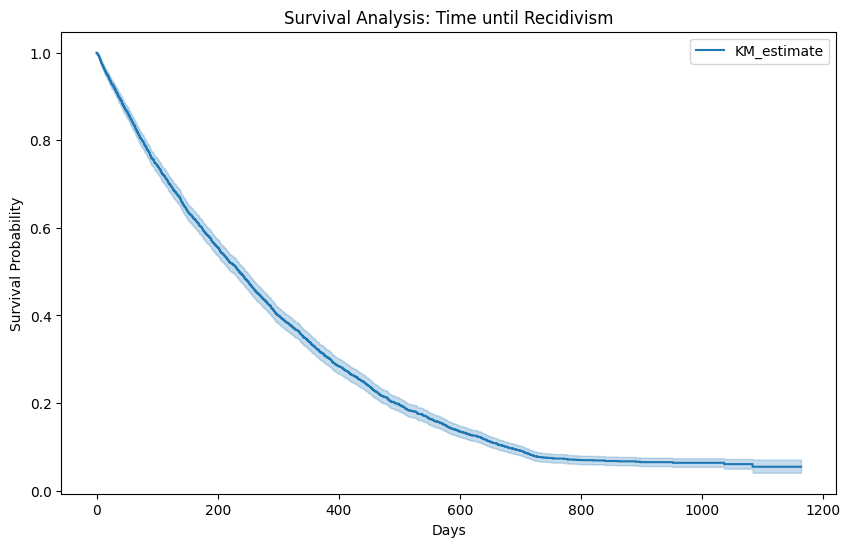

In [268]:
# Time to recidivism (Survival Analysis)
kmf = KaplanMeierFitter()

# Calculate time to recidivism and filter only positive values
df_cleaned_r = df_cleaned.dropna(subset=['r_offense_date'])
df_cleaned_r['time_to_recidivism'] = (df_cleaned_r['r_offense_date'] - df_cleaned_r['c_jail_in']).dt.days
df_cleaned_r = df_cleaned_r[df_cleaned_r['time_to_recidivism'] > 0]

T = df_cleaned_r['time_to_recidivism']
E = df_cleaned_r['is_recid']
kmf.fit(T, event_observed=E)
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Survival Analysis: Time until Recidivism')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

## Baseline Model

In [17]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def preprocess_data(df):
    # Convert columns to the specified types
    df = df.astype({
        "id": str,
        "name": str,
        "sex": str,
        "dob": str,
        "race": str,
        "juv_fel_count": int,
        "juv_misd_count": int,
        "juv_other_count": int,
        "priors_count": int,
        "c_case_number": str,
        "c_charge_degree": str,
        "c_charge_desc": str,
        "c_offense_date": str,
        "c_arrest_date": str,
        "c_jail_in": str
    })

    # Convert 'dob' to datetime
    df['dob'] = pd.to_datetime(df['dob'])

    # Create 'age_birth' feature
    df['age_birth'] = (pd.to_datetime('today') - df['dob']).dt.days // 365

    return df

# Split data into train and test sets first
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Apply preprocessing to both training and test sets
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

# Define features
all_features = [
    "id",
    "name",
    "sex",
#    "dob",
    "race",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "c_case_number",
    "c_charge_degree",
    "c_charge_desc",
    "c_offense_date",
    "c_arrest_date",
    "c_jail_in",
    "age_birth",
#    'is_recid'
]

numerical_features = [
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "age_birth"
]

categorical_features = [
    "id",
    "name",
    "sex",
  #  "dob",
    "race",
    "c_case_number",
    "c_charge_degree",
    "c_charge_desc",
    "c_offense_date",
    "c_arrest_date",
    "c_jail_in"
]

target = 'is_recid'

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the complete pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',   RandomForestClassifier()
    
    )]
    
    )

# Train the model
X_train = df_train[all_features]
y_train = df_train[target]
pipeline.fit(X_train, y_train)

# Evaluate on test set
X_test = df_test[all_features]
y_test = df_test[target]
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')


Accuracy: 0.67
Precision: 0.69
Recall: 0.50
F1-Score: 0.58
ROC-AUC: 0.66


In [58]:
import os

# Serialization
TMP_DIR = ''

# Serialize the column names from the X DataFrame into a file named columns.json
# YOUR CODE HERE
with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

# Pickle the dtypes of the columns from the X DataFrame into a file named dtypes.pickle
# YOUR CODE HERE
with open(os.path.join(TMP_DIR,'dtypes.pickle'), 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
# Pickle the fitted pipeline into a file named pipeline.pickle
# YOUR CODE HERE
import joblib
joblib.dump(pipeline, os.path.join(TMP_DIR,'pipeline.pickle'))

# Baseline Scoring
roc_auc_score(y_test, y_pred)

0.6614167224080267

## Testing the App

In [56]:
import requests
import json

url = "http://127.0.0.1:5000/will_recidivate"

data = {
    "id": "54567fgvhb214g91f1",
    "name": "John Doe",
    "sex": "Male",
    "dob": "1990-01-01",
    "race": "White",
    "juv_fel_count": 0,
    "juv_misd_count": 1,
    "juv_other_count": 0,
    "priors_count": 2,
    "c_case_number": "case123",
    "c_charge_degree": "M",
    "c_charge_desc": "Theft",
    "c_offense_date": "2023-01-01",
    "c_arrest_date": "2023-01-02",
    "c_jail_in": "2023-01-03"
}

headers = {'Content-Type': 'application/json'}
r = requests.post(url, data=json.dumps(data), headers=headers)

print("Response status code:", r.status_code)
print("Response content:", r.text)

Response status code: 200
Response content: {
  "error": "Observation ID: \"54567fgvhb214g91f1\" already exists",
  "id": "54567fgvhb214g91f1",
  "outcome": false
}



In [7]:
import requests

# Define the URL of your Flask application
url = 'http://127.0.0.1:5000/recidivism_result'  # Update with your actual URL

# Define the observation data
data = {
    "id": "54567fgvhb214g91f1",
    "outcome": True
}

headers = {'Content-Type': 'application/json'}
response = requests.post(url, data=json.dumps(data), headers=headers)

# Check the response status code
if response.status_code == 200:
    try:
        result = response.json()
        observation_id = result.get('id')  # Correct key
        outcome = result.get('outcome')  # Correct key
        predicted_outcome = result.get('predicted_outcome')  # Correct key
        if observation_id is not None and outcome is not None:
            print("Recidivism outcome updated successfully for ID:", observation_id)
            print("True outcome:", outcome)
            print("Predicted outcome:", predicted_outcome)
        else:
            print("Observation ID or outcome not found in the response")
    except ValueError:
        print("Failed to parse JSON response")
else:
    print("Failed to update recidivism outcome:", response.text)


Recidivism outcome updated successfully for ID: 54567fgvhb214g91f1
True outcome: True
Predicted outcome: False


In [6]:
import requests
import json

url = "https://capstone-production-4e96.up.railway.app/will_recidivate"

data = {
    "id": "54567fgvhb214g91",
    "name": "John Doe",
    "sex": "Male",
    "dob": "1990-01-01",
    "race": "White",
    "juv_fel_count": 0,
    "juv_misd_count": 1,
    "juv_other_count": 0,
    "priors_count": 2,
    "c_case_number": "case123",
    "c_charge_degree": "M",
    "c_charge_desc": "Theft",
    "c_offense_date": "2023-01-01",
    "c_arrest_date": "2023-01-02",
    "c_jail_in": "2023-01-03"
}

headers = {'Content-Type': 'application/json'}
r = requests.post(url, data=json.dumps(data), headers=headers)

print("Response status code:", r.status_code)
print("Response content:", r.text)

Response status code: 502
Response content: <!doctype html><meta name=viewport content="width=device-width,initial-scale=1"><meta charset=utf-8><title>502 Bad Gateway</title><style media=screen>
      :root {
        --bg: hsl(250, 24%, 9%);
        --fg: hsl(0, 0%, 100%);
        --pink: hsl(270, 60%, 52%);
        --pink-600: hsl(270, 70%, 65%);
        --green-600: hsl(152, 38%, 60%);
        --red-600: hsl(1, 62%, 60%);
        --gray-100: hsl(246, 18%, 15%);
        --gray-500: hsl(246,  6%, 55%);
      }

      html,
      body {
        margin: 0;
        padding: 10px;
        height: 100%;
        overflow: hidden;
        background-color: var(--bg);
        color: var(--fg);
        font-family: -apple-system, BlinkMacSystemFont, Segoe UI, Roboto,
          Oxygen-Sans, Ubuntu, Cantarell, Helvetica Neue, sans-serif,
          Apple Color Emoji, Segoe UI Emoji, Segoe UI Symbol;
        line-height: 1.4em;
      }

      main {
        display: flex;
        flex-direction: co

In [9]:
print("My numpy version is: ", np.__version__)

My numpy version is:  1.26.2


In [22]:
# List database contents
response = requests.get("https://capstone-production-fe3f.up.railway.app/list-db-contents")
print(response.json())


[]


In [24]:
# Test recidivism_result endpoint
response = requests.post(
    "https://capstone-production-fe3f.up.railway.app/recidivism_result",
    json={
        "id": "54567fgvhb214g91",
        "outcome": True
    }
)
print(response.json())


{'error': 'id does not exist'}


In [25]:
import requests

def test_will_recidivate():
    url = "https://capstone-production-fe3f.up.railway.app/will_recidivate"
    data = {
        "id": "123456a",
        "name": "John Doe",
        "sex": "Male",
        "dob": "1990-01-01",
        "race": "Caucasian",
        "juv_fel_count": 2,
        "juv_misd_count": 1,
        "juv_other_count": 0,
        "priors_count": 5,
        "c_case_number": "A123456",
        "c_charge_degree": "F",
        "c_charge_desc": "Burglary",
        "c_offense_date": "2022-01-01",
        "c_arrest_date": "2022-01-02",
        "c_jail_in": "2022-01-03"
    }

    try:
        response = requests.post(url, json=data)
        response.raise_for_status()  # Raise an error for bad status codes
        print(f"Status Code: {response.status_code}")
        print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        if response is not None:
            print(f"Status Code: {response.status_code}")
            print(response.text)

def test_recidivism_result():
    url = "https://capstone-production-fe3f.up.railway.app/recidivism_result"
    data = {
        "id": "123456a",
        "outcome": True
    }

    try:
        response = requests.post(url, json=data)
        response.raise_for_status()  # Raise an error for bad status codes
        print(f"Status Code: {response.status_code}")
        print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        if response is not None:
            print(f"Status Code: {response.status_code}")
            print(response.text)

def list_db_contents():
    url = "https://capstone-production-fe3f.up.railway.app/list-db-contents"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        print(f"Status Code: {response.status_code}")
        print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        if response is not None:
            print(f"Status Code: {response.status_code}")
            print(response.text)

# Run the tests
test_will_recidivate()
test_recidivism_result()
list_db_contents()


Status Code: 200
{'id': '123456a', 'outcome': True}
An error occurred: 400 Client Error: Bad Request for url: https://capstone-production-fe3f.up.railway.app/recidivism_result
Status Code: 400
{
  "error": "id does not exist"
}

Status Code: 200
[]


In [20]:
curl -X POST https://capstone-production-98d0.up.railway.app/will_recidivate -d '{
  "id": "12345abc",
  "name": "John Doe",
  "sex": "Male",
  "dob": "1990-01-01",
  "race": "Caucasian",
  "juv_fel_count": 2,
  "juv_misd_count": 1,
  "juv_other_count": 0,
  "priors_count": 5,
  "c_case_number": "A123456",
  "c_charge_degree": "F",
  "c_charge_desc": "Burglary",
  "c_offense_date": "2022-01-01",
  "c_arrest_date": "2022-01-02",
  "c_jail_in": "2022-01-03"
}' -H "Content-Type:application/json"


SyntaxError: invalid decimal literal (2704067808.py, line 1)

In [24]:
print("My numpy version is: ", np.__version__)

My numpy version is:  1.26.2
